In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Non-cyclic Stocks

### Kweichow Moutai Co., Ltd.

In [5]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14        OBV_7  labels
0  2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
1  2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2  2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
3  2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
4  2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


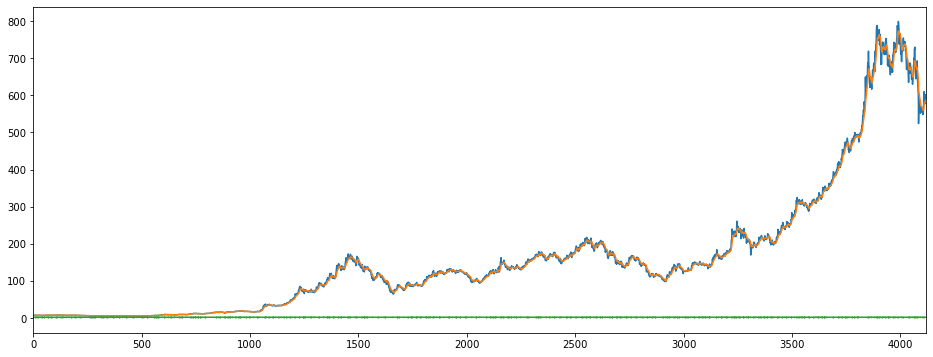

In [6]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [7]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2001-09-14,7.142585,7.257483,-41.873824,204624213.0,2.0
2001-09-17,7.224180,7.252359,-51.296847,208479649.0,2.0
2001-09-18,7.132634,7.233940,-72.964156,203965392.0,2.0
2001-09-19,7.214230,7.230908,-59.609037,209378730.0,2.0
2001-09-20,7.347568,7.248855,-37.785092,213725440.0,2.0


In [8]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_5_price = []
data_5_willr = []
data_5_ema = []
data_5_obv = []
count = 0

for i in df.values:
    if count == 4:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_price_arr = min_max_scaler.fit_transform(data_5_price)
        data_5_ema_arr = min_max_scaler.fit_transform(data_5_ema)
        data_5_willr_arr = min_max_scaler.fit_transform(data_5_willr)
        data_5_obv_arr = min_max_scaler.fit_transform(data_5_obv)
        price_data.append(data_5_price_arr)
        willr_data.append(data_5_willr_arr)
        ema_data.append(data_5_ema_arr)
        obv_data.append(data_5_obv_arr)
        labels.append(i[-1])
        data_5_price = data_5_price[1:]
        data_5_willr = data_5_willr[1:]
        data_5_obv = data_5_obv[1:]
        data_5_ema = data_5_ema[1:]
    
    else:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        count += 1

In [9]:
willr_data = np.array(willr_data)
willr_data.shape

(4116, 5, 1)

In [10]:
price_data = np.array(price_data)
price_data.shape

(4116, 5, 1)

In [11]:
ema_data = np.array(ema_data)
ema_data.shape

(4116, 5, 1)

In [12]:
obv_data = np.array(obv_data)
obv_data.shape

(4116, 5, 1)

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [14]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4116, 64, 64, 1)

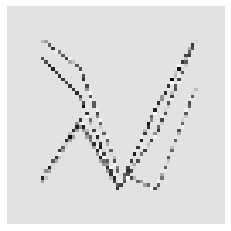

In [15]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [16]:
X = X/255

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [18]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.364653243847875, 1: 7.5159817351598175, 2: 0.36614392169947724}
Epoch 1/200
 1/26 [>.............................] - ETA: 0s - loss: 0.5160 - accuracy: 0.6484 - mse: 5.6132 - weighted_accuracy: 0.2993 - weighted_mse: 7.3376WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
26/26 [==============================] - 1s 25ms/step - loss: 0.2473 - accuracy: 0.3092 - mse: 1.7048 - weighted_accuracy: 0.3279 - weighted_mse: 1.7943 - val_loss: 0.2077 - val_accuracy: 0.0801 - val_mse: 0.8929 - val_weighted_accuracy: 0.0801 - val_weighted_mse: 0.8929
Epoch 2/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2087 - accuracy: 0.2327 - mse: 1.2116 - weighted_accuracy: 0.3253 - weighted_mse: 1.1827 - val_loss: 0.1991 - val_accuracy: 0.0546 - v

Epoch 27/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1854 - accuracy: 0.2251 - mse: 1.2602 - weighted_accuracy: 0.4973 - weighted_mse: 1.2218 - val_loss: 0.1965 - val_accuracy: 0.0886 - val_mse: 1.0376 - val_weighted_accuracy: 0.0886 - val_weighted_mse: 1.0376
Epoch 28/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1853 - accuracy: 0.2117 - mse: 1.3018 - weighted_accuracy: 0.4949 - weighted_mse: 1.2642 - val_loss: 0.2044 - val_accuracy: 0.0777 - val_mse: 1.0285 - val_weighted_accuracy: 0.0777 - val_weighted_mse: 1.0285
Epoch 29/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1849 - accuracy: 0.1978 - mse: 1.2499 - weighted_accuracy: 0.4827 - weighted_mse: 1.2221 - val_loss: 0.1956 - val_accuracy: 0.0947 - val_mse: 1.0357 - val_weighted_accuracy: 0.0947 - val_weighted_mse: 1.0357
Epoch 30/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1870 - accuracy: 0.2257 - mse: 1.2762 - weighted_accuracy: 0.5148 - weig

Epoch 56/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1680 - accuracy: 0.2014 - mse: 1.4398 - weighted_accuracy: 0.5705 - weighted_mse: 1.4247 - val_loss: 0.2020 - val_accuracy: 0.1044 - val_mse: 1.2056 - val_weighted_accuracy: 0.1044 - val_weighted_mse: 1.2056
Epoch 57/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1667 - accuracy: 0.1968 - mse: 1.4570 - weighted_accuracy: 0.5795 - weighted_mse: 1.4352 - val_loss: 0.2041 - val_accuracy: 0.0959 - val_mse: 1.1882 - val_weighted_accuracy: 0.0959 - val_weighted_mse: 1.1882
Epoch 58/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1692 - accuracy: 0.1987 - mse: 1.4709 - weighted_accuracy: 0.5610 - weighted_mse: 1.4037 - val_loss: 0.1969 - val_accuracy: 0.1323 - val_mse: 1.2550 - val_weighted_accuracy: 0.1323 - val_weighted_mse: 1.2550
Epoch 59/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1705 - accuracy: 0.2123 - mse: 1.4424 - weighted_accuracy: 0.5853 - weig

Epoch 85/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1542 - accuracy: 0.2749 - mse: 1.5657 - weighted_accuracy: 0.6382 - weighted_mse: 1.5183 - val_loss: 0.2008 - val_accuracy: 0.2051 - val_mse: 1.3601 - val_weighted_accuracy: 0.2051 - val_weighted_mse: 1.3601
Epoch 86/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1538 - accuracy: 0.2971 - mse: 1.5366 - weighted_accuracy: 0.6569 - weighted_mse: 1.4979 - val_loss: 0.2001 - val_accuracy: 0.1760 - val_mse: 1.4396 - val_weighted_accuracy: 0.1760 - val_weighted_mse: 1.4396
Epoch 87/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1528 - accuracy: 0.2871 - mse: 1.6518 - weighted_accuracy: 0.6490 - weighted_mse: 1.6078 - val_loss: 0.2039 - val_accuracy: 0.1687 - val_mse: 1.2495 - val_weighted_accuracy: 0.1687 - val_weighted_mse: 1.2495
Epoch 88/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1503 - accuracy: 0.3177 - mse: 1.5651 - weighted_accuracy: 0.6494 - weig

Epoch 114/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1445 - accuracy: 0.3697 - mse: 1.6696 - weighted_accuracy: 0.6747 - weighted_mse: 1.6730 - val_loss: 0.1938 - val_accuracy: 0.2949 - val_mse: 1.5425 - val_weighted_accuracy: 0.2949 - val_weighted_mse: 1.5425
Epoch 115/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1367 - accuracy: 0.3700 - mse: 1.7797 - weighted_accuracy: 0.6986 - weighted_mse: 1.8193 - val_loss: 0.1762 - val_accuracy: 0.4102 - val_mse: 1.5842 - val_weighted_accuracy: 0.4102 - val_weighted_mse: 1.5842
Epoch 116/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1402 - accuracy: 0.3906 - mse: 1.7548 - weighted_accuracy: 0.6890 - weighted_mse: 1.7860 - val_loss: 0.1812 - val_accuracy: 0.3617 - val_mse: 1.5035 - val_weighted_accuracy: 0.3617 - val_weighted_mse: 1.5035
Epoch 117/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1370 - accuracy: 0.4116 - mse: 1.8233 - weighted_accuracy: 0.7049 - 

Epoch 143/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1229 - accuracy: 0.5267 - mse: 1.8766 - weighted_accuracy: 0.7494 - weighted_mse: 2.0852 - val_loss: 0.1715 - val_accuracy: 0.4636 - val_mse: 1.5398 - val_weighted_accuracy: 0.4636 - val_weighted_mse: 1.5398
Epoch 144/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1227 - accuracy: 0.5079 - mse: 1.9284 - weighted_accuracy: 0.7446 - weighted_mse: 2.1672 - val_loss: 0.1759 - val_accuracy: 0.4248 - val_mse: 1.5500 - val_weighted_accuracy: 0.4248 - val_weighted_mse: 1.5500
Epoch 145/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1232 - accuracy: 0.5085 - mse: 1.8404 - weighted_accuracy: 0.7535 - weighted_mse: 2.0261 - val_loss: 0.1645 - val_accuracy: 0.5303 - val_mse: 1.6465 - val_weighted_accuracy: 0.5303 - val_weighted_mse: 1.6465
Epoch 146/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1187 - accuracy: 0.5012 - mse: 1.9462 - weighted_accuracy: 0.7658 - 

26/26 [==============================] - 0s 10ms/step - loss: 0.1051 - accuracy: 0.6300 - mse: 1.9919 - weighted_accuracy: 0.8150 - weighted_mse: 2.5243 - val_loss: 0.1577 - val_accuracy: 0.5934 - val_mse: 1.8679 - val_weighted_accuracy: 0.5934 - val_weighted_mse: 1.8679
Epoch 172/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1056 - accuracy: 0.6403 - mse: 1.9340 - weighted_accuracy: 0.8059 - weighted_mse: 2.4186 - val_loss: 0.1459 - val_accuracy: 0.6396 - val_mse: 1.6259 - val_weighted_accuracy: 0.6396 - val_weighted_mse: 1.6259
Epoch 173/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1004 - accuracy: 0.6543 - mse: 2.0110 - weighted_accuracy: 0.8176 - weighted_mse: 2.5824 - val_loss: 0.1438 - val_accuracy: 0.6675 - val_mse: 1.7207 - val_weighted_accuracy: 0.6675 - val_weighted_mse: 1.7207
Epoch 174/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1023 - accuracy: 0.6376 - mse: 1.9276 - weighted_accuracy: 0.8242 - weighted_m

Epoch 200/200
26/26 [==============================] - 0s 9ms/step - loss: 0.0826 - accuracy: 0.7491 - mse: 2.0775 - weighted_accuracy: 0.8630 - weighted_mse: 2.9981 - val_loss: 0.1225 - val_accuracy: 0.7731 - val_mse: 1.7141 - val_weighted_accuracy: 0.7731 - val_weighted_mse: 1.7141


In [22]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12246612459421158
Test accuracy: 0.7730582356452942


In [23]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.96894085 -1.0225874  -0.2696105 ]
 [-0.80034685 -1.4627049  -0.13288501]
 [-1.1258562  -1.3281876   0.07552886]
 ...
 [-1.3234494  -0.81577814 -0.24700776]
 [-1.420697   -0.77785623 -0.23658605]
 [-1.1855903  -1.5995675   0.10111503]]


Counter({2: 667, 1: 82, 0: 75})

In [24]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 750, 0: 37, 1: 37})

In [25]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 824
actual predicted buys: 11
actual buys but predicted sell: 1
actual buys but predicted hold: 25
actual sells but predicted buy: 1
actual predicted sells: 10
actual sells but predicted hold: 26
actual holds but predicted buy: 70
actual holds but predicted sell: 64
actual predicted holds: 616
Percentage buys correct: 29.72972972972973%
Percentage sells correct: 27.027027027027028%
Percentage holds correct: 82.13333333333334%
actual buys: 37
actual sells: 37
actual holds: 750


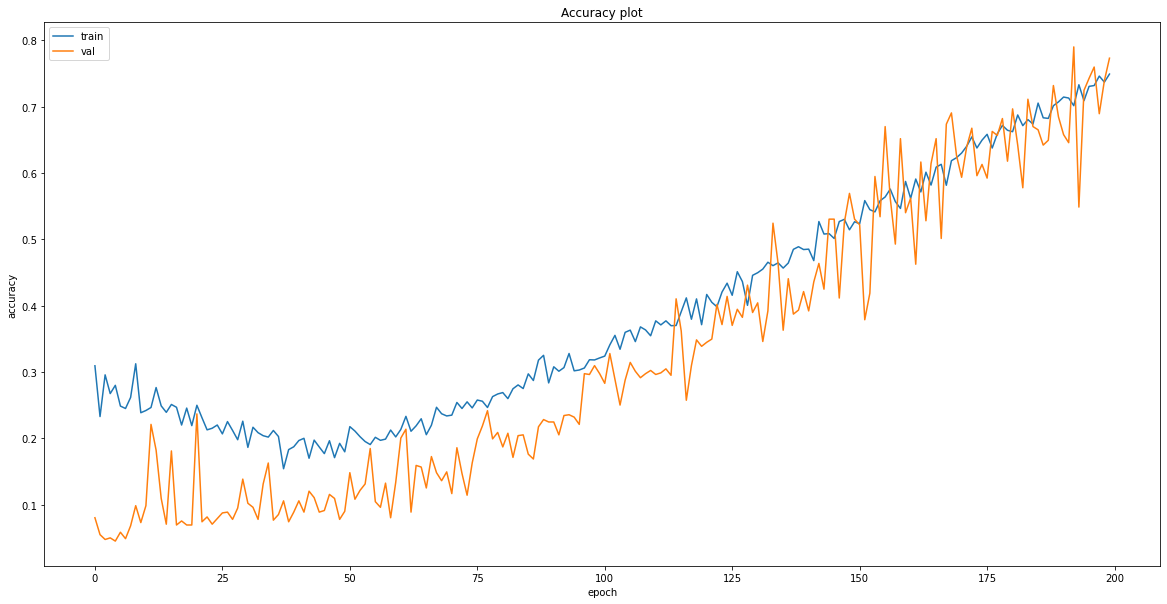

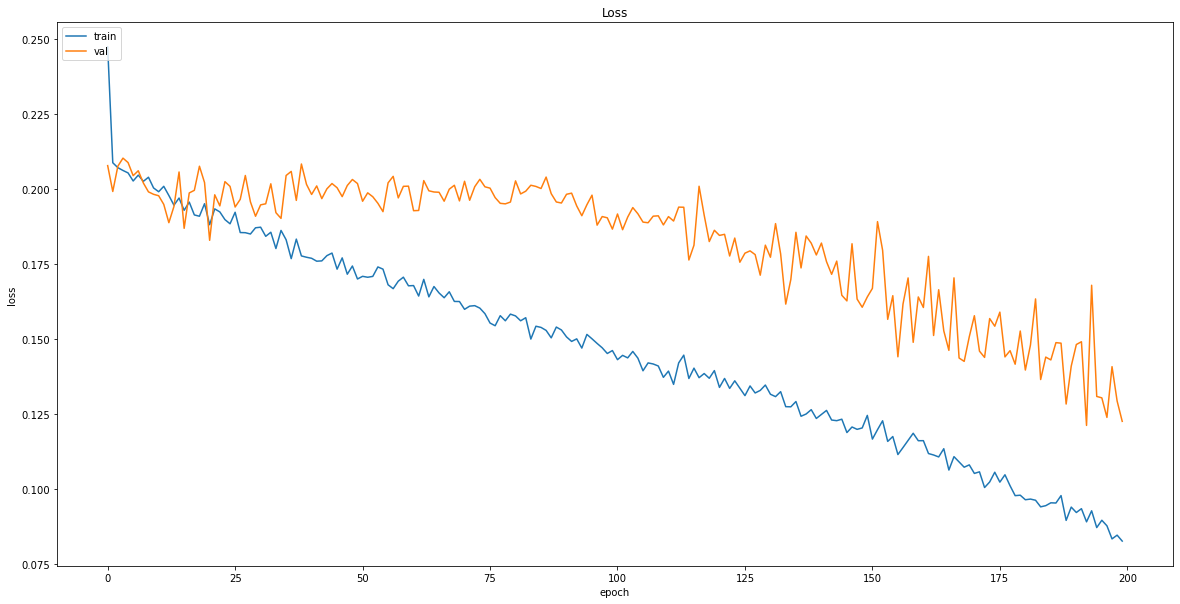

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
# Save model
model.save("models/{}".format('moutai_image_cnn_buy_hold_sell_5.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/moutai_image_cnn_buy_hold_sell_5.model\assets


### Test Performance

### non-recession

In [28]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-02-12   725.299988  680.857339  -5.533611  42959323.0     2.0
2019-02-13   717.919983  686.559284 -15.712368  39450180.0     2.0
2019-02-14   735.250000  694.050163  -1.218823  43017886.0     2.0
2019-02-15   737.159973  700.682442  -8.071529  46243699.0     2.0
2019-02-18   724.780029  704.389763 -23.444619  43919901.0     2.0


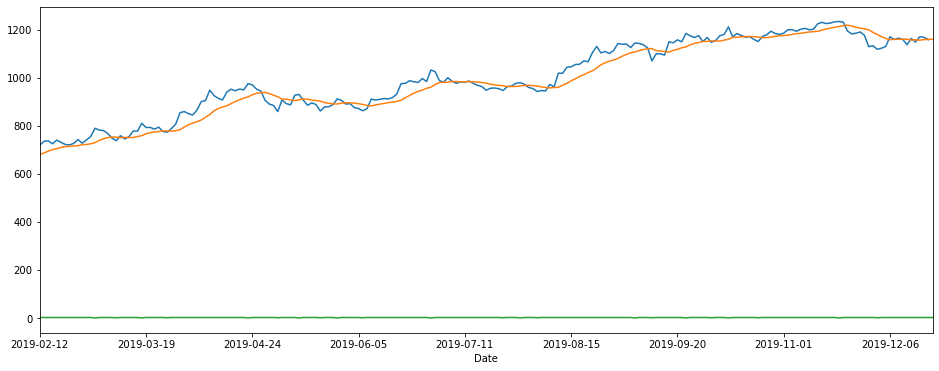

In [29]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [30]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_5_price = []
data_5_willr = []
data_5_ema = []
data_5_obv = []
count = 0

for i in df.values:
    if count == 4:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_price_arr = min_max_scaler.fit_transform(data_5_price)
        data_5_ema_arr = min_max_scaler.fit_transform(data_5_ema)
        data_5_willr_arr = min_max_scaler.fit_transform(data_5_willr)
        data_5_obv_arr = min_max_scaler.fit_transform(data_5_obv)
        price_data.append(data_5_price_arr)
        willr_data.append(data_5_willr_arr)
        ema_data.append(data_5_ema_arr)
        obv_data.append(data_5_obv_arr)
        labels.append(i[-1])
        data_5_price = data_5_price[1:]
        data_5_willr = data_5_willr[1:]
        data_5_obv = data_5_obv[1:]
        data_5_ema = data_5_ema[1:]
    
    else:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        count += 1

In [31]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [33]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [34]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [35]:
model = tf.keras.models.load_model("models/moutai_image_cnn_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 7ms/step - loss: 0.1222 - accuracy: 0.7295 - mean_squared_error: 1.7266 - weighted_accuracy: 0.7295 - weighted_mean_squared_error: 1.7266
Test loss: 0.12222118675708771
Test accuracy: 0.729468584060669


In [36]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 158, 0: 28, 1: 21})

In [37]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 185, 0: 11, 1: 11})

In [38]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-18,740.00000,704.389763,-23.444619,43919901.0,2.0,2,2
2019-02-19,730.76001,709.868261,-6.049880,47694490.0,2.0,2,2
2019-02-20,722.00000,713.082376,-17.677836,44744340.0,2.0,2,2
2019-02-21,720.25000,714.454318,-29.824573,40956103.0,2.0,2,2
2019-02-22,726.01001,715.345962,-32.098776,37971063.0,2.0,2,2


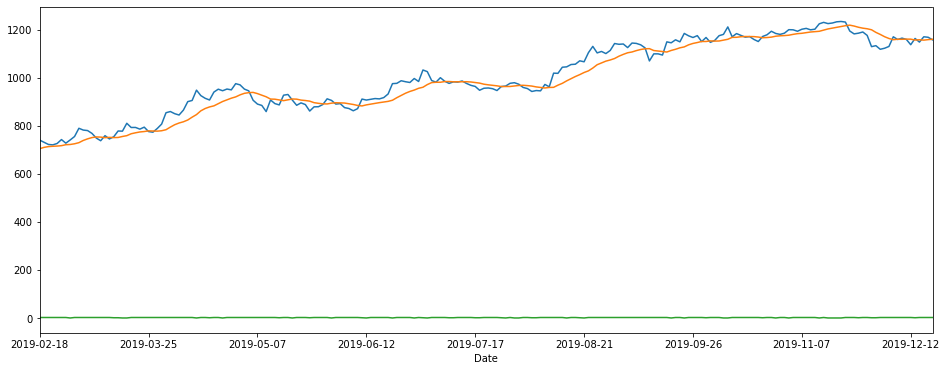

In [39]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

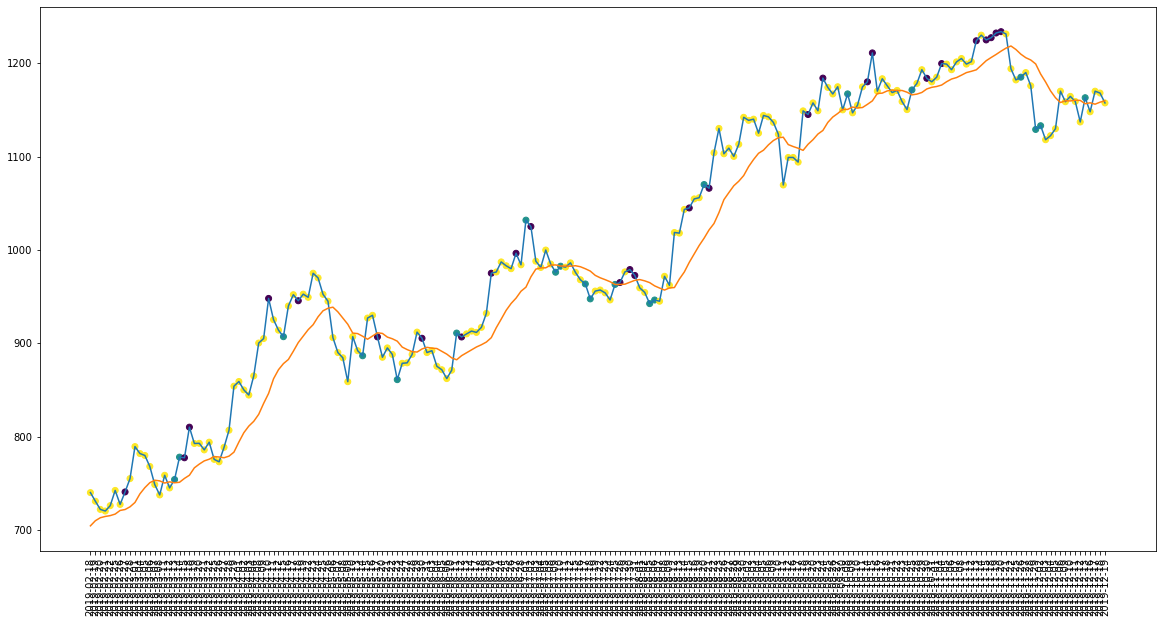

In [40]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

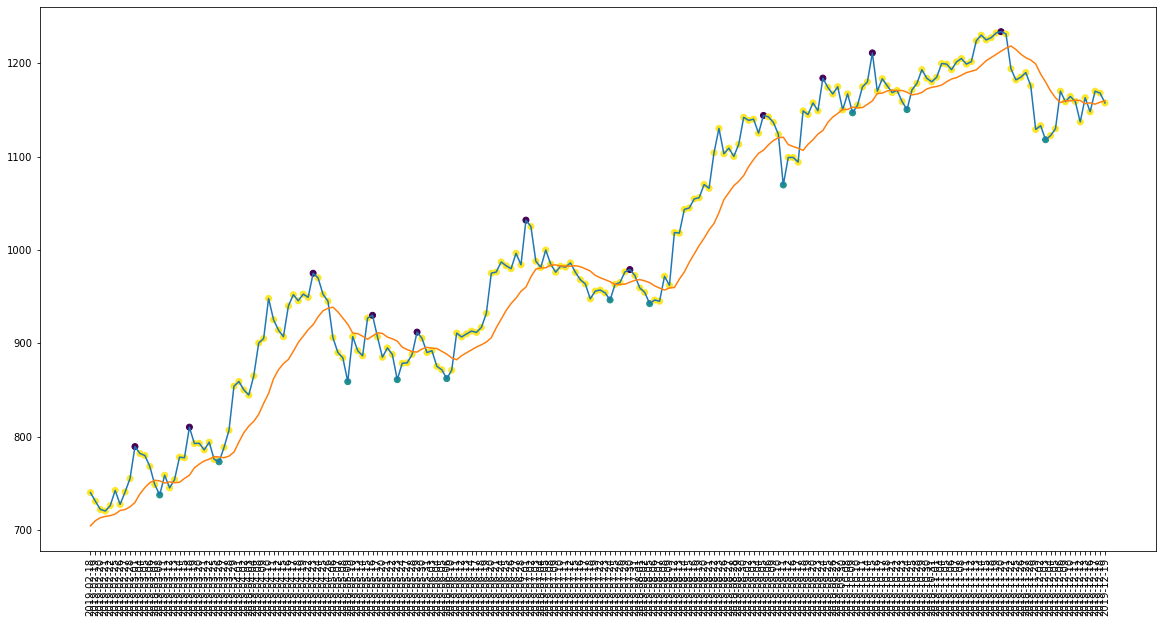

In [41]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [42]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 207
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 5
actual holds but predicted buy: 18
actual holds but predicted sell: 23
actual predicted holds: 144
Percentage buys correct: 18.181818181818183%
Percentage sells correct: 45.45454545454545%
Percentage holds correct: 77.83783783783784%
actual buys: 11
actual sells: 11
actual holds: 185


In [43]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[720.25, 722.0, 726.010009765625, 727.3499755859375, 730.760009765625, 740.0, 740.7000122070312, 742.3300170898438, 755.010009765625]
[727.3499755859375, 737.5, 740.7000122070312, 748.5999755859375, 755.010009765625, 768.0, 779.780029296875, 781.8599853515625, 789.2999877929688]
Percentage buys correct: 42.857142857142854%
Percentage sells correct: 55.55555555555556%
Percentage holds correct: 86.70886075949367%


In [44]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $754.0
Shares owned at the moment: 13
Cash capital at the moment: $171.04449999999997


Price increase from previously bought: 7.144348645398724%
Share price: $810.0900268554688
Shares owned at the moment: 0
Cash capital at the moment: $10673.254130661011


Share price: $907.0
Shares owned at the moment: 11
Cash capital at the moment: $668.8173806610102


Stop Loss Activated!

Share price: $858.8099975585938
Shares owned at the moment: 0
Cash capital at the moment: $10089.748351379394


Share price: $886.5700073242188
Shares owned at the moment: 11
Cash capital at the moment: $310.6595280914298


Stop Loss Activated!

Share price: $861.0
Shares owned at the moment: 0
Cash capital at the moment: $9755.614278091429


Share price: $861.0
Shares owned at the moment: 11
Cash capital at the moment: $258.56902809142775


Price increase from previously bought: 5.018980869627243%
Share price: $906.7000122070312
Shares owned at the moment: 0
Cash capital at the moment: $10204.841486

In [45]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $15358.36826651001
profit gained: 53.5836826651001%


### Recession

In [46]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/600519.SS_data_test2.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
print(df.head())

            previous_1d       EMA_12   willr_14      OBV_7  labels
Date                                                              
2020-02-13  1097.270020  1076.474651 -15.554098  4904879.0     2.0
2020-02-14  1091.000000  1078.709320 -17.096133  1869143.0     2.0
2020-02-17  1088.000000  1080.138656 -19.336778  -459617.0     2.0
2020-02-18  1093.819946  1082.243470 -14.989967  2243205.0     2.0
2020-02-19  1084.000000  1082.513705 -22.324305  -423291.0     2.0


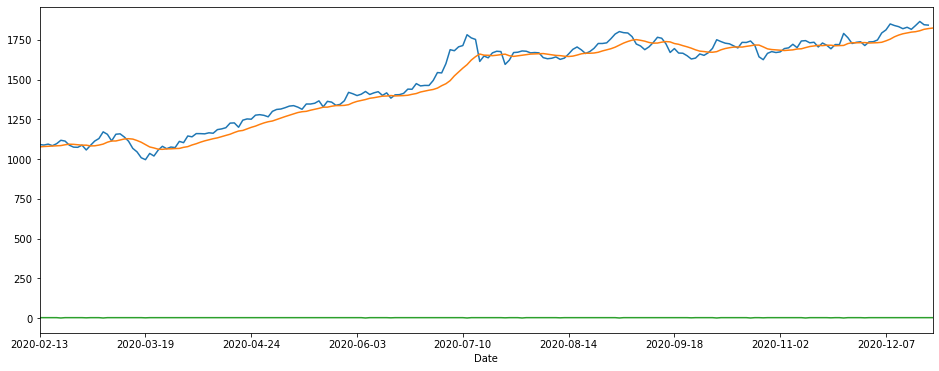

In [47]:
#%matplotlib notebook
df['previous_1d'].shift(-1).plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [48]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_5_price = []
data_5_willr = []
data_5_ema = []
data_5_obv = []
count = 0

for i in df.values:
    if count == 4:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_price_arr = min_max_scaler.fit_transform(data_5_price)
        data_5_ema_arr = min_max_scaler.fit_transform(data_5_ema)
        data_5_willr_arr = min_max_scaler.fit_transform(data_5_willr)
        data_5_obv_arr = min_max_scaler.fit_transform(data_5_obv)
        price_data.append(data_5_price_arr)
        willr_data.append(data_5_willr_arr)
        ema_data.append(data_5_ema_arr)
        obv_data.append(data_5_obv_arr)
        labels.append(i[-1])
        data_5_price = data_5_price[1:]
        data_5_willr = data_5_willr[1:]
        data_5_obv = data_5_obv[1:]
        data_5_ema = data_5_ema[1:]
    
    else:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        count += 1

In [49]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [51]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [52]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [53]:
model = tf.keras.models.load_model("models/moutai_image_cnn_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 6ms/step - loss: 0.1274 - accuracy: 0.7596 - mean_squared_error: 1.6779 - weighted_accuracy: 0.7596 - weighted_mean_squared_error: 1.6779
Test loss: 0.1274445801973343
Test accuracy: 0.7596153616905212


In [54]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 171, 0: 26, 1: 11})

In [55]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [56]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,1096.500000,1082.513705,-22.324305,-423291.0,2.0,2,2
2020-02-20,1118.000000,1084.665443,-12.988283,3281856.0,0.0,2,0
2020-02-21,1112.880005,1089.793836,-4.166667,7962118.0,2.0,2,2
2020-02-24,1087.180054,1093.345554,-10.201830,5068110.0,2.0,2,2
2020-02-25,1074.810059,1092.397016,-40.474836,1203074.0,2.0,2,2


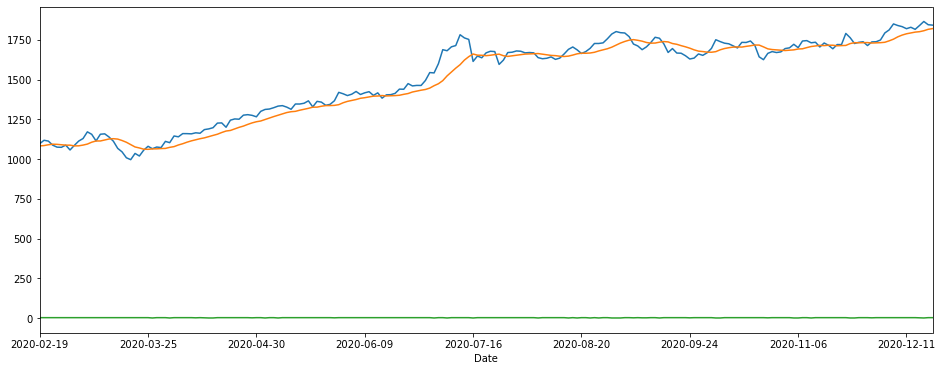

In [57]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

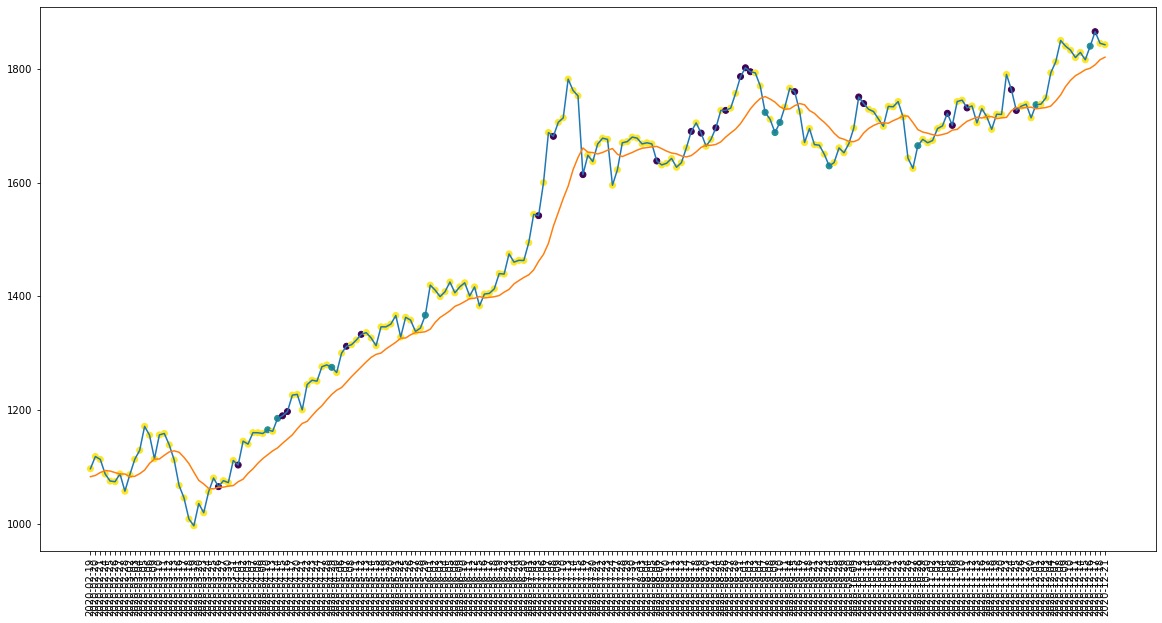

In [58]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

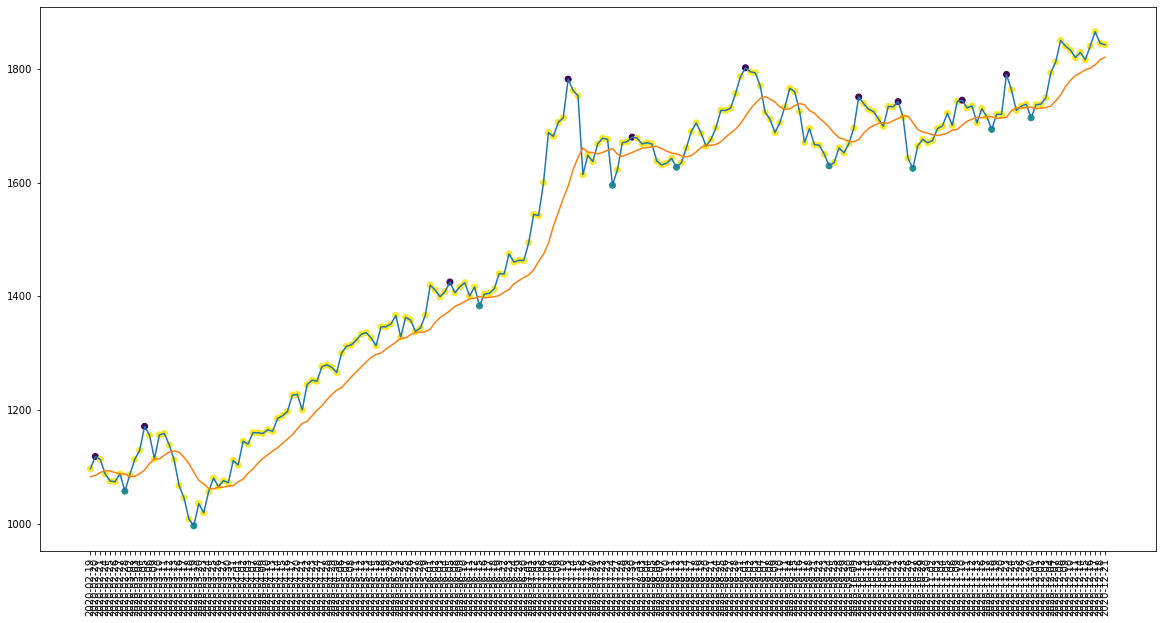

In [59]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [60]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 208
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 10
actual holds but predicted sell: 24
actual predicted holds: 155
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 20.0%
Percentage holds correct: 82.01058201058201%
actual buys: 9
actual sells: 10
actual holds: 189


In [61]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[1057.0, 1073.699951171875, 1074.81005859375, 1086.010009765625, 1087.1800537109377, 1087.3900146484377, 1096.5, 1112.8800048828123, 1118.0]
[1057.0, 1086.010009765625, 1087.3900146484377, 1113.0, 1114.010009765625, 1128.9200439453125, 1155.5, 1156.0, 1171.0]
Percentage buys correct: 63.63636363636363%
Percentage sells correct: 46.15384615384615%
Percentage holds correct: 85.29411764705883%


In [62]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $1165.0
Shares owned at the moment: 8
Cash capital at the moment: $654.369999999999


Price increase from previously bought: 12.309175518397364%
Share price: $1312.0
Shares owned at the moment: 0
Cash capital at the moment: $11121.506


Share price: $1366.5999755859375
Shares owned at the moment: 8
Cash capital at the moment: $158.64099584960786


Price increase from previously bought: 12.510008176059761%
Share price: $1541.7900390625
Shares owned at the moment: 0
Cash capital at the moment: $12459.041927490232


Share price: $1723.5
Shares owned at the moment: 7
Cash capital at the moment: $361.3645524902313


Stop Loss Activated!

Share price: $1670.52001953125
Shares owned at the moment: 0
Cash capital at the moment: $12022.847178833004


Share price: $1629.3199462890625
Shares owned at the moment: 7
Cash capital at the moment: $586.2431458435021


Price increase from previously bought: 7.149551231404305%
Share price: $1750.6099853515625
Shares owned at the moment: 0
Ca

In [63]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16641.259749999997
profit gained: 66.41259749999998%


### Midea Group

In [64]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14        OBV_7  labels
0  2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
1  2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2  2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
3  2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
4  2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


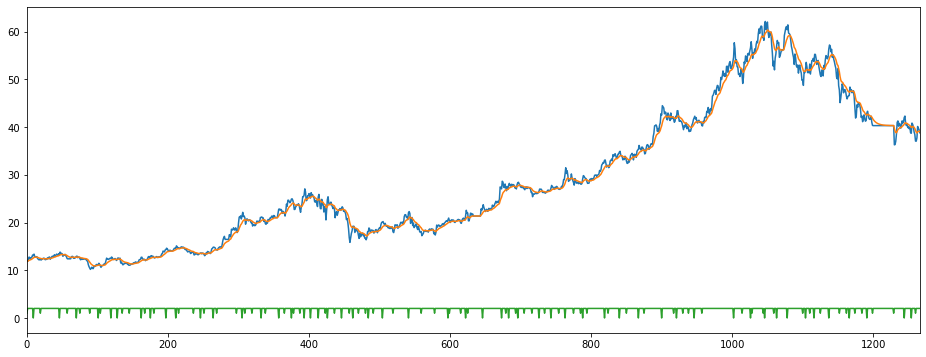

In [65]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [66]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2013-10-17,11.912000,11.900182,-34.022038,235647532.0,1.0
2013-10-18,11.896000,11.899539,-39.103542,214825024.0,2.0
2013-10-21,12.269333,11.956430,-24.093825,253903732.0,2.0
2013-10-22,12.760000,12.080056,-4.424713,304775737.0,2.0
2013-10-23,12.645333,12.167022,-15.187657,273970459.0,2.0


In [67]:
# willr_data = []
# price_data = []
# ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1

In [68]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_5_price = []
data_5_willr = []
data_5_ema = []
data_5_obv = []
count = 0

for i in df.values:
    if count == 4:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_price_arr = min_max_scaler.fit_transform(data_5_price)
        data_5_ema_arr = min_max_scaler.fit_transform(data_5_ema)
        data_5_willr_arr = min_max_scaler.fit_transform(data_5_willr)
        data_5_obv_arr = min_max_scaler.fit_transform(data_5_obv)
        price_data.append(data_5_price_arr)
        willr_data.append(data_5_willr_arr)
        ema_data.append(data_5_ema_arr)
        obv_data.append(data_5_obv_arr)
        labels.append(i[-1])
        data_5_price = data_5_price[1:]
        data_5_willr = data_5_willr[1:]
        data_5_obv = data_5_obv[1:]
        data_5_ema = data_5_ema[1:]
    
    else:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        count += 1

In [69]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [71]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(1263, 64, 64, 1)

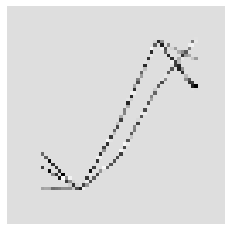

In [72]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [73]:
X = X/255

In [74]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [75]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [76]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [77]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [78]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 8.015873015873016, 1: 6.733333333333333, 2: 0.36673928830791575}
Epoch 1/200
8/8 [==============================] - 3s 430ms/step - loss: 0.3308 - accuracy: 0.4683 - mse: 2.6863 - weighted_accuracy: 0.2916 - weighted_mse: 2.8732 - val_loss: 0.1863 - val_accuracy: 0.3715 - val_mse: 1.5015 - val_weighted_accuracy: 0.3715 - val_weighted_mse: 1.5015
Epoch 2/200
8/8 [==============================] - 0s 14ms/step - loss: 0.2442 - accuracy: 0.3168 - mse: 1.5775 - weighted_accuracy: 0.2764 - weighted_mse: 1.5705 - val_loss: 0.2101 - val_accuracy: 0.0553 - val_mse: 0.9128 - val_weighted_accuracy: 0.0553 - val_weighted_mse: 0.9128
Epoch 3/200
8/8 [==============================] - 0s 12ms/step - loss: 0.2078 - accuracy: 0.2861 - mse: 1.2421 - weighted_accuracy: 0.3472 - weighted_mse: 1.1888 - val_loss: 0.2051 - val_accuracy: 0.0632 - val_mse: 1.0836 - val_weighted_accuracy: 0.0632 - val_weighted_mse: 1.0836
Epoch 4/200
8/8 [==============================] - 0s 11ms/step - loss: 0.2113 - acc

Epoch 29/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1939 - accuracy: 0.2703 - mse: 1.1956 - weighted_accuracy: 0.4624 - weighted_mse: 1.1852 - val_loss: 0.2065 - val_accuracy: 0.0711 - val_mse: 0.9964 - val_weighted_accuracy: 0.0711 - val_weighted_mse: 0.9964
Epoch 30/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1966 - accuracy: 0.2406 - mse: 1.1226 - weighted_accuracy: 0.4162 - weighted_mse: 1.1250 - val_loss: 0.1963 - val_accuracy: 0.0553 - val_mse: 1.0636 - val_weighted_accuracy: 0.0553 - val_weighted_mse: 1.0636
Epoch 31/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1970 - accuracy: 0.3782 - mse: 1.2315 - weighted_accuracy: 0.3923 - weighted_mse: 1.2249 - val_loss: 0.1857 - val_accuracy: 0.4387 - val_mse: 0.9318 - val_weighted_accuracy: 0.4387 - val_weighted_mse: 0.9318
Epoch 32/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1972 - accuracy: 0.4228 - mse: 1.1521 - weighted_accuracy: 0.3884 - weighted

Epoch 58/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1862 - accuracy: 0.3465 - mse: 1.2972 - weighted_accuracy: 0.4891 - weighted_mse: 1.3044 - val_loss: 0.1844 - val_accuracy: 0.1897 - val_mse: 1.0727 - val_weighted_accuracy: 0.1897 - val_weighted_mse: 1.0727
Epoch 59/200
8/8 [==============================] - 0s 12ms/step - loss: 0.1833 - accuracy: 0.3901 - mse: 1.2736 - weighted_accuracy: 0.5064 - weighted_mse: 1.3084 - val_loss: 0.1958 - val_accuracy: 0.1186 - val_mse: 0.9465 - val_weighted_accuracy: 0.1186 - val_weighted_mse: 0.9465
Epoch 60/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1869 - accuracy: 0.2455 - mse: 1.1718 - weighted_accuracy: 0.5328 - weighted_mse: 1.1614 - val_loss: 0.2003 - val_accuracy: 0.0830 - val_mse: 1.1036 - val_weighted_accuracy: 0.0830 - val_weighted_mse: 1.1036
Epoch 61/200
8/8 [==============================] - 0s 12ms/step - loss: 0.1820 - accuracy: 0.3050 - mse: 1.2636 - weighted_accuracy: 0.5104 - weighted

Epoch 87/200
8/8 [==============================] - 0s 12ms/step - loss: 0.1620 - accuracy: 0.3634 - mse: 1.4358 - weighted_accuracy: 0.6404 - weighted_mse: 1.4974 - val_loss: 0.1801 - val_accuracy: 0.2846 - val_mse: 1.2367 - val_weighted_accuracy: 0.2846 - val_weighted_mse: 1.2367
Epoch 88/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1663 - accuracy: 0.3050 - mse: 1.4888 - weighted_accuracy: 0.5836 - weighted_mse: 1.4453 - val_loss: 0.1902 - val_accuracy: 0.1304 - val_mse: 1.2396 - val_weighted_accuracy: 0.1304 - val_weighted_mse: 1.2396
Epoch 89/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1724 - accuracy: 0.3079 - mse: 1.4947 - weighted_accuracy: 0.5608 - weighted_mse: 1.4298 - val_loss: 0.1822 - val_accuracy: 0.2213 - val_mse: 1.2470 - val_weighted_accuracy: 0.2213 - val_weighted_mse: 1.2470
Epoch 90/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1664 - accuracy: 0.3574 - mse: 1.3704 - weighted_accuracy: 0.6079 - weighted

Epoch 116/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1612 - accuracy: 0.3644 - mse: 1.6366 - weighted_accuracy: 0.5839 - weighted_mse: 1.5945 - val_loss: 0.1845 - val_accuracy: 0.2569 - val_mse: 1.3090 - val_weighted_accuracy: 0.2569 - val_weighted_mse: 1.3090
Epoch 117/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1614 - accuracy: 0.3188 - mse: 1.4897 - weighted_accuracy: 0.5698 - weighted_mse: 1.4625 - val_loss: 0.1903 - val_accuracy: 0.2055 - val_mse: 1.3114 - val_weighted_accuracy: 0.2055 - val_weighted_mse: 1.3114
Epoch 118/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1590 - accuracy: 0.3495 - mse: 1.6192 - weighted_accuracy: 0.6277 - weighted_mse: 1.5958 - val_loss: 0.1747 - val_accuracy: 0.3834 - val_mse: 1.2792 - val_weighted_accuracy: 0.3834 - val_weighted_mse: 1.2792
Epoch 119/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1601 - accuracy: 0.3901 - mse: 1.4218 - weighted_accuracy: 0.6615 - weig

Epoch 145/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1452 - accuracy: 0.4614 - mse: 1.8315 - weighted_accuracy: 0.6952 - weighted_mse: 1.7849 - val_loss: 0.1748 - val_accuracy: 0.4071 - val_mse: 1.4624 - val_weighted_accuracy: 0.4071 - val_weighted_mse: 1.4624
Epoch 146/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1416 - accuracy: 0.4020 - mse: 1.6786 - weighted_accuracy: 0.6974 - weighted_mse: 1.7233 - val_loss: 0.1817 - val_accuracy: 0.3636 - val_mse: 1.4270 - val_weighted_accuracy: 0.3636 - val_weighted_mse: 1.4270
Epoch 147/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1426 - accuracy: 0.4218 - mse: 1.7790 - weighted_accuracy: 0.6958 - weighted_mse: 1.7284 - val_loss: 0.1798 - val_accuracy: 0.3557 - val_mse: 1.5039 - val_weighted_accuracy: 0.3557 - val_weighted_mse: 1.5039
Epoch 148/200
8/8 [==============================] - 0s 10ms/step - loss: 0.1479 - accuracy: 0.3950 - mse: 1.6096 - weighted_accuracy: 0.6709 - weig

Epoch 174/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1357 - accuracy: 0.5267 - mse: 1.8308 - weighted_accuracy: 0.7116 - weighted_mse: 1.8517 - val_loss: 0.1673 - val_accuracy: 0.5217 - val_mse: 1.3337 - val_weighted_accuracy: 0.5217 - val_weighted_mse: 1.3337
Epoch 175/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1404 - accuracy: 0.5574 - mse: 1.6610 - weighted_accuracy: 0.6901 - weighted_mse: 1.6693 - val_loss: 0.1705 - val_accuracy: 0.5099 - val_mse: 1.3694 - val_weighted_accuracy: 0.5099 - val_weighted_mse: 1.3694
Epoch 176/200
8/8 [==============================] - 0s 12ms/step - loss: 0.1302 - accuracy: 0.4871 - mse: 1.7087 - weighted_accuracy: 0.7135 - weighted_mse: 1.8529 - val_loss: 0.1690 - val_accuracy: 0.5020 - val_mse: 1.4811 - val_weighted_accuracy: 0.5020 - val_weighted_mse: 1.4811
Epoch 177/200
8/8 [==============================] - 0s 11ms/step - loss: 0.1306 - accuracy: 0.5158 - mse: 1.8302 - weighted_accuracy: 0.7429 - weig

In [79]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.15690161287784576
Test accuracy: 0.5889328122138977


In [80]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.8638948   0.14022356 -0.8472203 ]
 [-0.23682345 -1.0713388  -0.4893669 ]
 [-2.1771781  -0.04412106 -0.74612963]
 [-1.5243003  -0.8017757  -0.15401909]
 [-0.14467047 -1.1316289  -0.49452627]
 [-0.5322524  -0.82167906 -0.3967958 ]
 [-1.3915249   0.03672585 -0.55534923]
 [-0.2843452  -1.640619   -0.5695685 ]
 [-0.98518676 -1.1882741  -0.11069527]
 [-2.025363    0.11386419 -0.7689502 ]
 [-0.9978095  -0.5105448  -0.38587338]
 [-1.3909454  -0.7037497  -0.3397988 ]
 [-0.8094813  -0.90261257 -0.23408675]
 [-0.29518592 -1.2085527  -0.4327128 ]
 [-1.5025679  -0.2106727  -0.5017555 ]
 [-0.06273417 -1.8843509  -0.74306977]
 [-1.1086074  -0.827942   -0.27781874]
 [-0.8884334  -1.09936    -0.1795629 ]
 [-0.6604783  -1.3536197  -0.24337217]
 [-1.3599156  -0.5685345  -0.3889578 ]
 [-1.7481192  -0.27584895 -0.55262625]
 [-1.3981293  -0.32898977 -0.45746642]
 [-0.72760844 -1.2652375  -0.22856939]
 [-1.5143584  -0.32083568 -0.45731285]
 [-1.8967279  -1.099983   -0.09473203]
 [-1.9746633  -0.08252022

Counter({1: 56, 0: 47, 2: 150})

In [81]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 230, 1: 12, 0: 11})

In [82]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 253
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 4
actual holds but predicted buy: 49
actual holds but predicted sell: 42
actual predicted holds: 139
Percentage buys correct: 41.666666666666664%
Percentage sells correct: 45.45454545454545%
Percentage holds correct: 60.43478260869565%
actual buys: 12
actual sells: 11
actual holds: 230


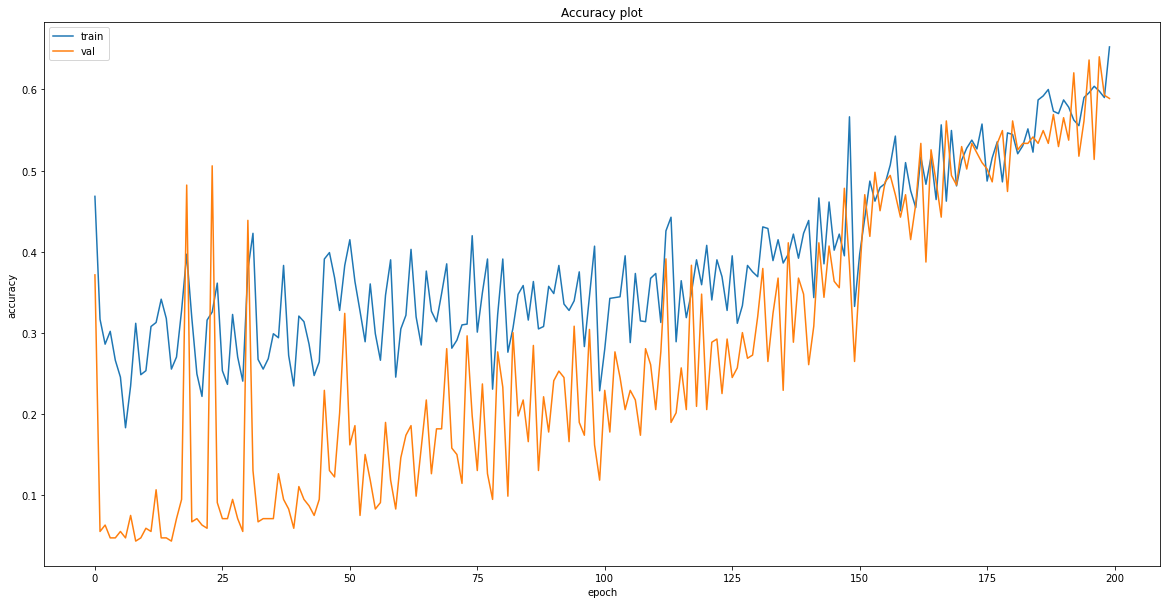

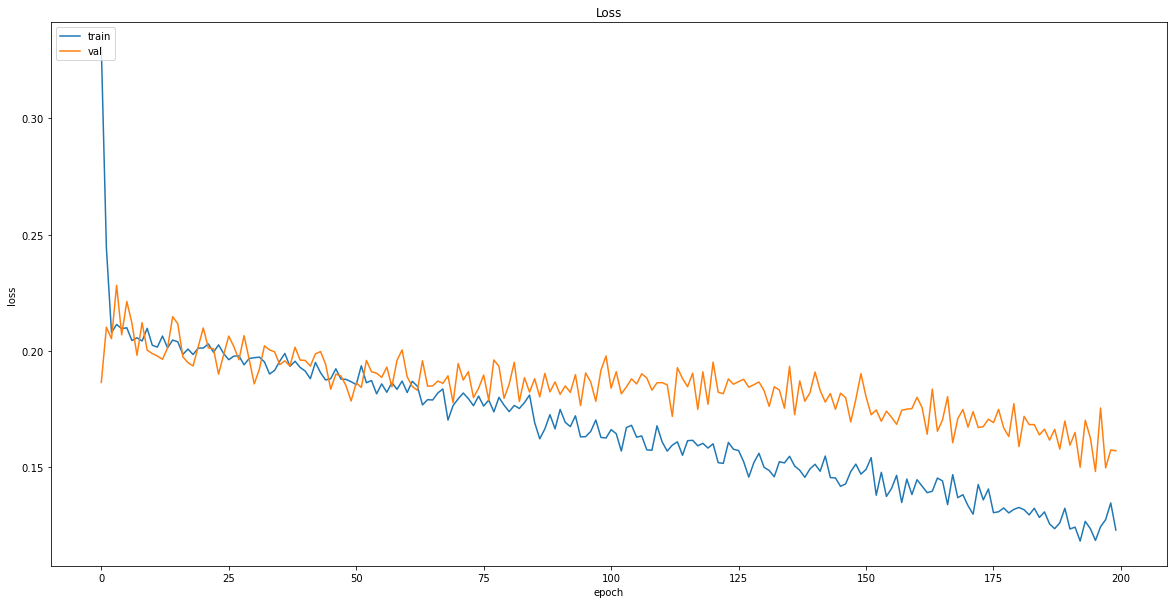

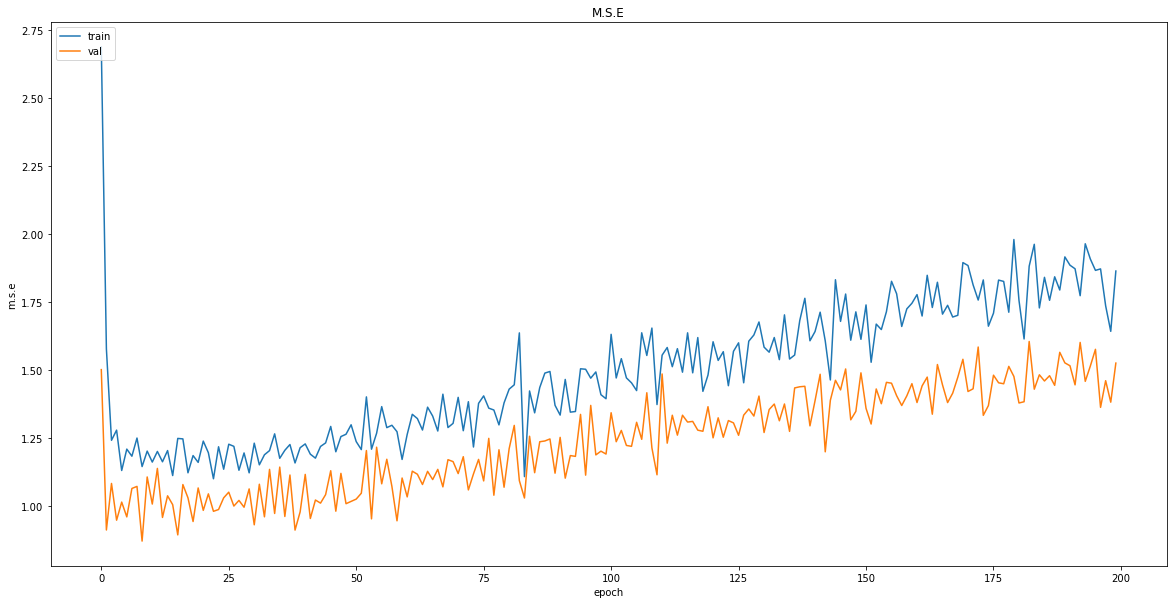

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [84]:
# Save model
model.save("models/{}".format('midea_image_cnn_buy_hold_sell_5.model'))

INFO:tensorflow:Assets written to: models/midea_image_cnn_buy_hold_sell_5.model\assets


### Test Performance

#### Non-Recession

In [85]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-02-12    46.080002  42.654367  -4.210488  380829366.0     2.0
2019-02-13    46.490002  43.244464  -6.612900  411118769.0     2.0
2019-02-14    46.799999  43.791470  -6.584998  443533043.0     2.0
2019-02-15    47.150002  44.308167  -2.420572  466454440.0     2.0
2019-02-18    45.270000  44.456141 -30.862341  419918481.0     2.0


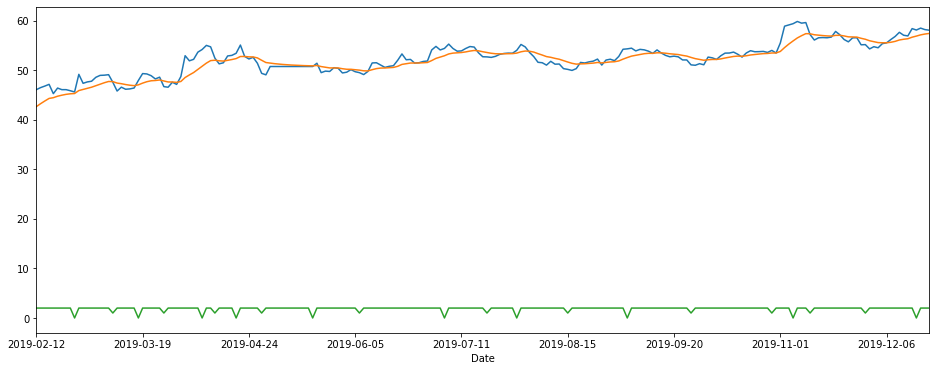

In [86]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [87]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_5_price = []
data_5_willr = []
data_5_ema = []
data_5_obv = []
count = 0

for i in df.values:
    if count == 4:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_price_arr = min_max_scaler.fit_transform(data_5_price)
        data_5_ema_arr = min_max_scaler.fit_transform(data_5_ema)
        data_5_willr_arr = min_max_scaler.fit_transform(data_5_willr)
        data_5_obv_arr = min_max_scaler.fit_transform(data_5_obv)
        price_data.append(data_5_price_arr)
        willr_data.append(data_5_willr_arr)
        ema_data.append(data_5_ema_arr)
        obv_data.append(data_5_obv_arr)
        labels.append(i[-1])
        data_5_price = data_5_price[1:]
        data_5_willr = data_5_willr[1:]
        data_5_obv = data_5_obv[1:]
        data_5_ema = data_5_ema[1:]
    
    else:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [89]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [90]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [91]:
model = tf.keras.models.load_model("models/midea_image_cnn_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1553 - accuracy: 0.5894 - mean_squared_error: 1.5764 - weighted_accuracy: 0.5894 - weighted_mean_squared_error: 1.5764
Test loss: 0.15528424084186554
Test accuracy: 0.5893719792366028


In [92]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 122, 1: 42, 0: 43})

In [93]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 186, 0: 10, 1: 11})

In [94]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-18,46.400002,44.456141,-30.862341,419918481.0,2.0,2,2
2019-02-19,46.080002,44.755197,-13.767016,452488699.0,2.0,2,2
2019-02-20,46.080002,44.959013,-18.975880,424412835.0,2.0,2,2
2019-02-21,45.860001,45.131473,-18.975880,424412835.0,2.0,2,2
2019-02-22,45.610001,45.243554,-26.174460,382970560.0,2.0,1,2


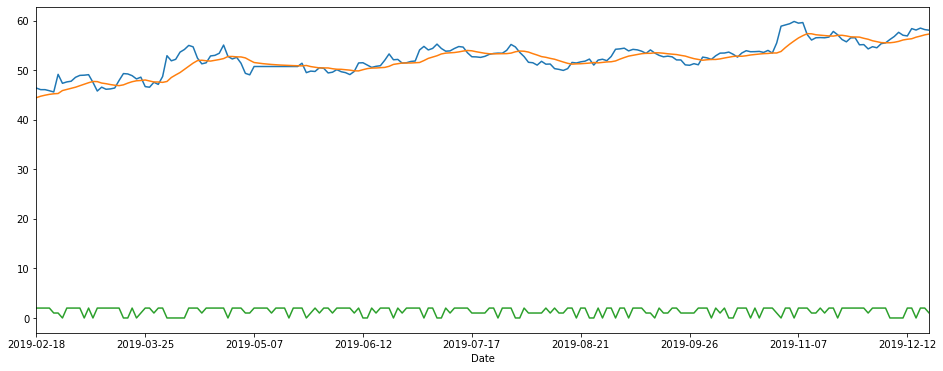

In [95]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

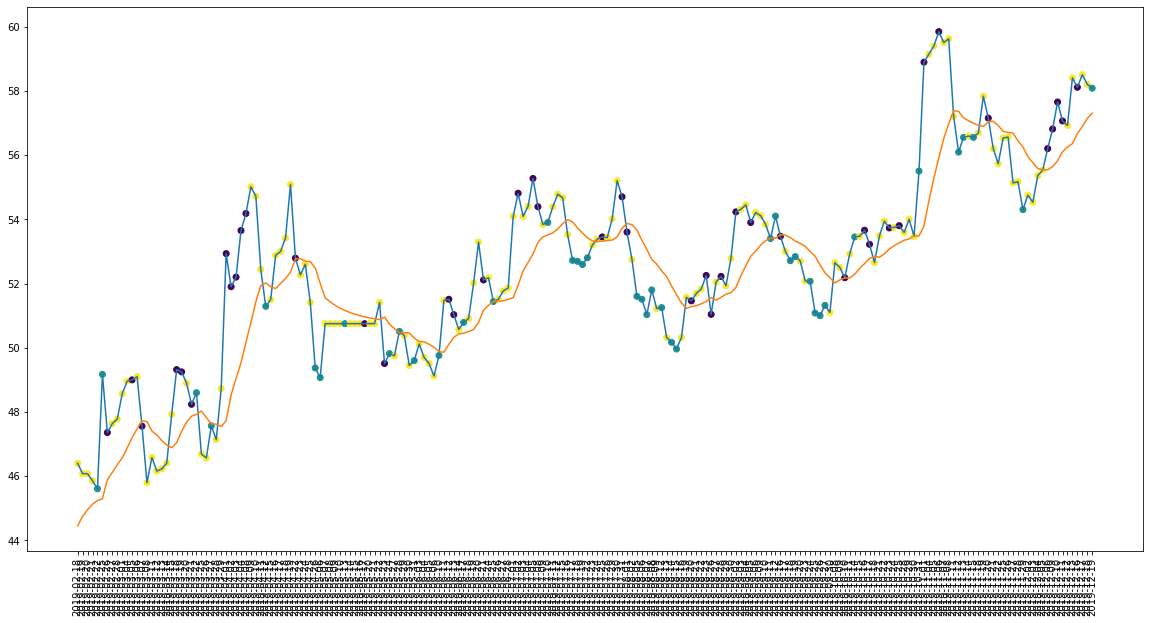

In [96]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

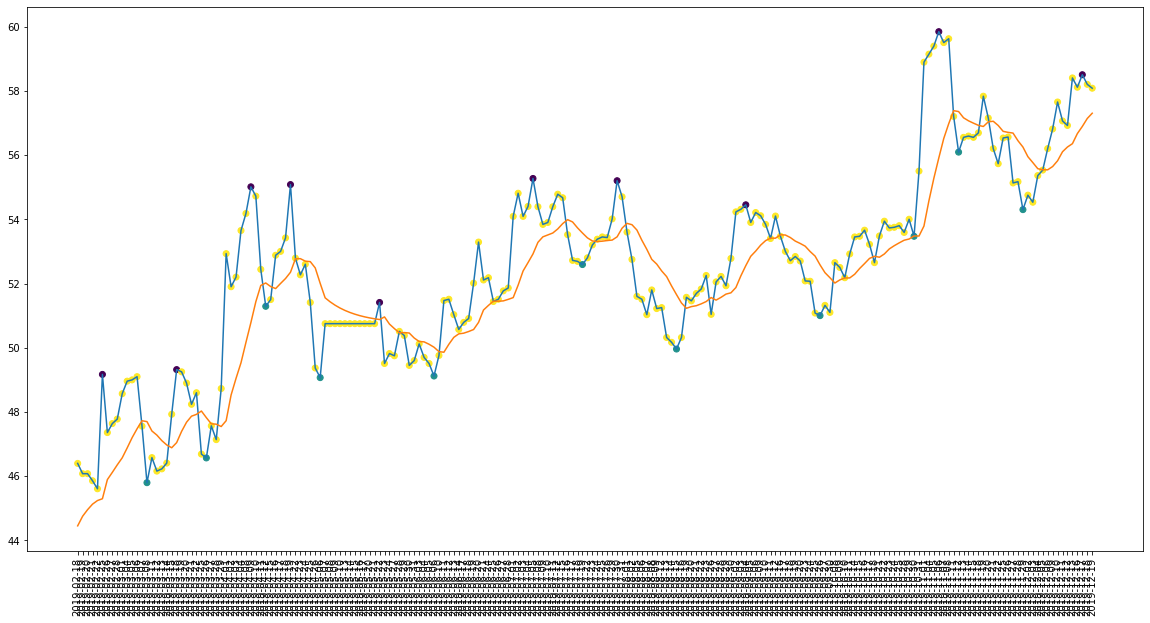

In [97]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [98]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 207
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 34
actual holds but predicted sell: 40
actual predicted holds: 112
Percentage buys correct: 63.63636363636363%
Percentage sells correct: 30.0%
Percentage holds correct: 60.215053763440864%
actual buys: 11
actual sells: 10
actual holds: 186


In [99]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[45.61000061035156, 45.86000061035156, 46.08000183105469, 46.08000183105469, 46.4000015258789, 47.36000061035156, 47.63999938964844, 47.77999877929688, 49.16999816894531]
[45.79999923706055, 47.36000061035156, 47.56000137329102, 47.63999938964844, 47.77999877929688, 48.56999969482422, 48.959999084472656, 49.0, 49.099998474121094]
Percentage buys correct: 75.60975609756098%
Percentage sells correct: 55.81395348837209%
Percentage holds correct: 81.14754098360656%


In [100]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $45.61000061035156
Shares owned at the moment: 218
Cash capital at the moment: $29.676671577453817


Price increase from previously bought: 7.137949774895125%
Share price: $49.0
Shares owned at the moment: 0
Cash capital at the moment: $10682.301171577454


Share price: $48.599998474121094
Shares owned at the moment: 219
Cash capital at the moment: $9.63215666389442


Stop Loss Activated!

Share price: $46.68999862670898
Shares owned at the moment: 0
Cash capital at the moment: $10206.622804240224


Share price: $47.56999969482422
Shares owned at the moment: 213
Cash capital at the moment: $46.348741921421606


Price increase from previously bought: 10.962460223533%
Share price: $52.93000030517578
Shares owned at the moment: 0
Cash capital at the moment: $11289.435059245106


Share price: $51.290000915527344
Shares owned at the moment: 219
Cash capital at the moment: $26.0354556932416


Stop Loss Activated!

Share price: $49.36999893188477
Shares owned at the moment: 0
Cas

In [101]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12438.033583332062
profit gained: 24.380335833320625%


#### Recession

In [102]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/000333.SZ_data_test2.csv")
df = df.iloc[10:]
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-02-13    54.889999  54.718954 -53.549524  20343150.0     2.0
2020-02-14    53.799999  54.577577 -63.102549 -11587509.0     2.0
2020-02-17    53.740002  54.448719 -63.500423 -32591896.0     2.0
2020-02-18    54.400002  54.441224 -52.704009    -86645.0     2.0
2020-02-19    53.529999  54.301035 -52.927131 -33290149.0     2.0


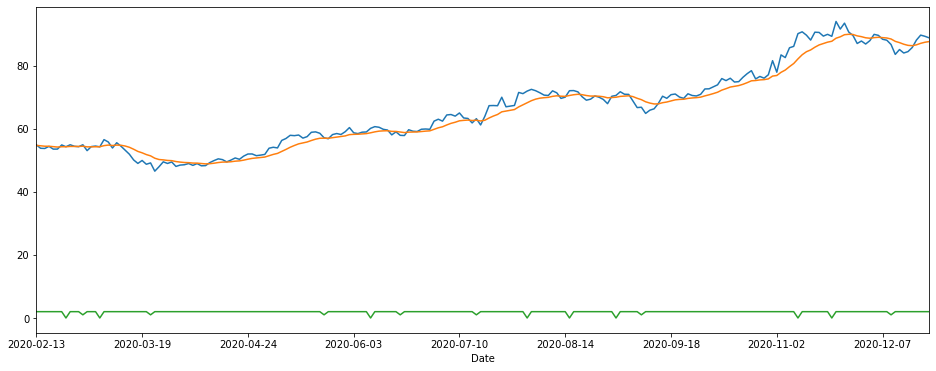

In [103]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [104]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_5_price = []
data_5_willr = []
data_5_ema = []
data_5_obv = []
count = 0

for i in df.values:
    if count == 4:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_price_arr = min_max_scaler.fit_transform(data_5_price)
        data_5_ema_arr = min_max_scaler.fit_transform(data_5_ema)
        data_5_willr_arr = min_max_scaler.fit_transform(data_5_willr)
        data_5_obv_arr = min_max_scaler.fit_transform(data_5_obv)
        price_data.append(data_5_price_arr)
        willr_data.append(data_5_willr_arr)
        ema_data.append(data_5_ema_arr)
        obv_data.append(data_5_obv_arr)
        labels.append(i[-1])
        data_5_price = data_5_price[1:]
        data_5_willr = data_5_willr[1:]
        data_5_obv = data_5_obv[1:]
        data_5_ema = data_5_ema[1:]
    
    else:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [105]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [106]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [107]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [108]:
model = tf.keras.models.load_model("models/midea_image_cnn_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1577 - accuracy: 0.5481 - mean_squared_error: 1.6088 - weighted_accuracy: 0.5481 - weighted_mean_squared_error: 1.6088
Test loss: 0.15766844153404236
Test accuracy: 0.5480769276618958


In [109]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 119, 1: 51, 0: 38})

In [110]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 8, 1: 7})

In [111]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-19,53.540001,54.301035,-52.927131,-33290149.0,2.0,2,2
2020-02-20,54.860001,54.183953,-44.755246,-9557295.0,2.0,2,2
2020-02-21,54.279999,54.287960,-8.665511,27483857.0,2.0,2,2
2020-02-24,54.910000,54.286736,-21.343904,-2296012.0,0.0,2,0
2020-02-25,54.430000,54.382622,-12.602723,38486402.0,2.0,2,2


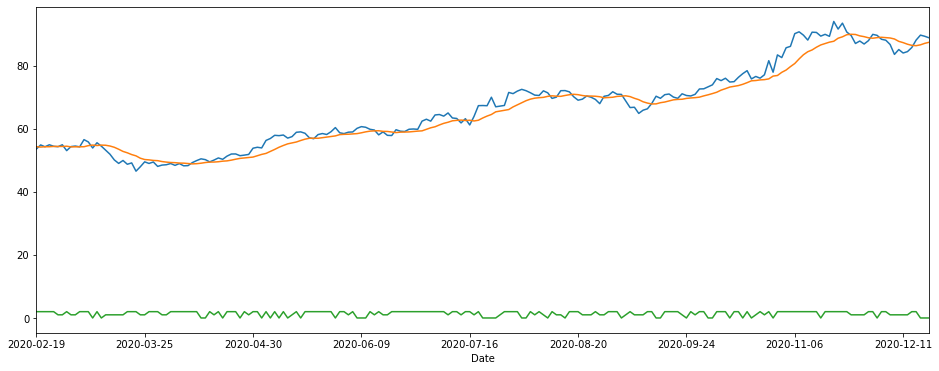

In [112]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

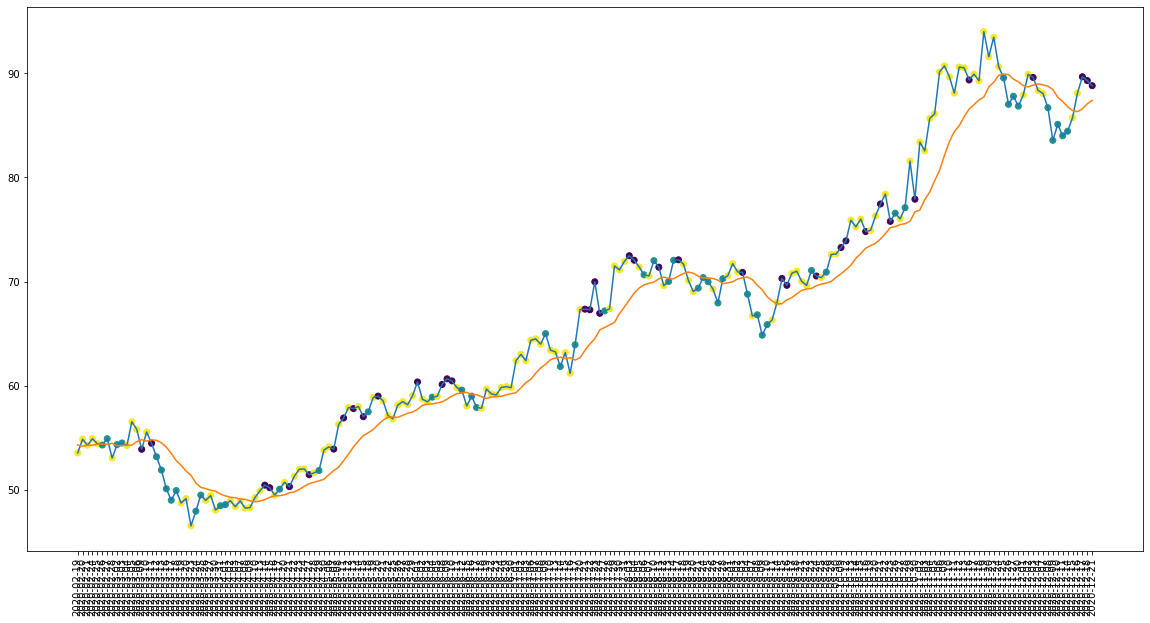

In [113]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

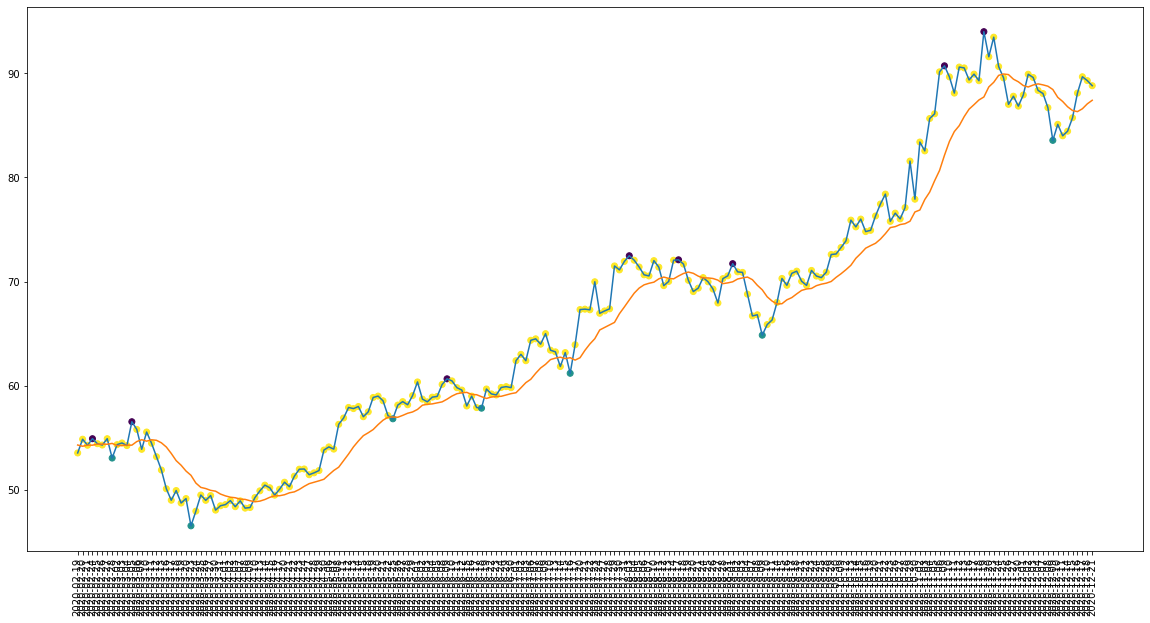

In [114]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [115]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 208
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 49
actual holds but predicted sell: 35
actual predicted holds: 109
Percentage buys correct: 28.571428571428573%
Percentage sells correct: 37.5%
Percentage holds correct: 56.476683937823836%
actual buys: 7
actual sells: 8
actual holds: 193


In [116]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[53.04999923706055, 53.540000915527344, 54.27999877929688, 54.29999923706055, 54.34000015258789, 54.43000030517578, 54.86000061035156, 54.90999984741211, 54.90999984741211]
[53.04999923706055, 53.88999938964844, 54.25, 54.34000015258789, 54.5, 54.90999984741211, 55.54999923706055, 55.79999923706055, 56.540000915527344]
Percentage buys correct: 60.0%
Percentage sells correct: 55.26315789473684%
Percentage holds correct: 86.5546218487395%


In [117]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $54.29999923706055
Shares owned at the moment: 183
Cash capital at the moment: $35.77366500186872


Stop Loss Activated!

Share price: $51.9000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9507.355268469808


Share price: $51.9000015258789
Shares owned at the moment: 182
Cash capital at the moment: $35.57903999614609


Stop Loss Activated!

Share price: $50.099998474121094
Shares owned at the moment: 0
Cash capital at the moment: $9128.703713049887


Share price: $50.099998474121094
Shares owned at the moment: 181
Cash capital at the moment: $35.66671499347467


Stop Loss Activated!

Share price: $48.72999954223633
Shares owned at the moment: 0
Cash capital at the moment: $8831.541274866102


Share price: $47.95000076293945
Shares owned at the moment: 183
Cash capital at the moment: $32.56029736423261


Price increase from previously bought: 7.005006189830909%
Share price: $51.45000076293945
Shares owned at the moment: 0
Cash capital at the moment: $

In [118]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $16487.407351390837
profit gained: 64.87407351390837%


## Walmart

In [119]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
1  2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2  2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
3  2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
4  2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


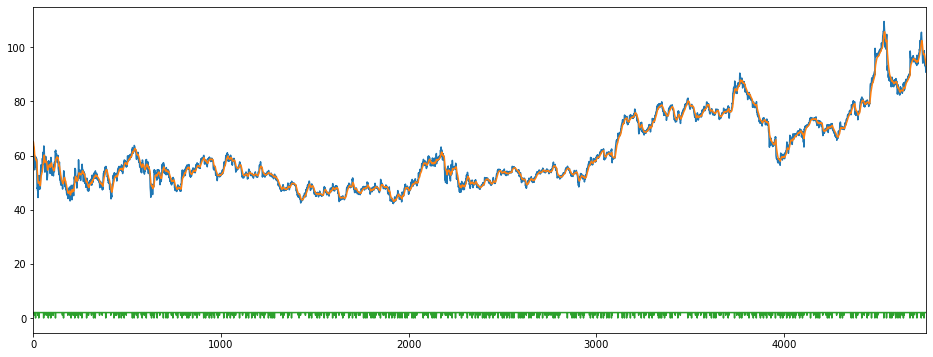

In [120]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [121]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,63.3750,65.176128,-85.271318,-26649200.0,2.0
2000-01-24,62.4375,64.754801,-94.594595,-33601700.0,2.0
2000-01-25,59.3750,63.927139,-83.606557,-41401600.0,2.0
2000-01-26,61.1250,63.496041,-68.306011,-34997800.0,2.0
2000-01-27,61.9375,63.256265,-61.202186,-30459400.0,2.0


In [122]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_5_price = []
data_5_willr = []
data_5_ema = []
data_5_obv = []
count = 0

for i in df.values:
    if count == 4:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_price_arr = min_max_scaler.fit_transform(data_5_price)
        data_5_ema_arr = min_max_scaler.fit_transform(data_5_ema)
        data_5_willr_arr = min_max_scaler.fit_transform(data_5_willr)
        data_5_obv_arr = min_max_scaler.fit_transform(data_5_obv)
        price_data.append(data_5_price_arr)
        willr_data.append(data_5_willr_arr)
        ema_data.append(data_5_ema_arr)
        obv_data.append(data_5_obv_arr)
        labels.append(i[-1])
        data_5_price = data_5_price[1:]
        data_5_willr = data_5_willr[1:]
        data_5_obv = data_5_obv[1:]
        data_5_ema = data_5_ema[1:]
    
    else:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        count += 1

In [123]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [124]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [125]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4755, 64, 64, 1)

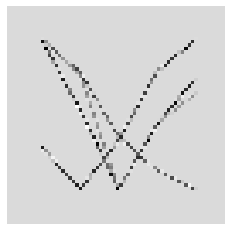

In [126]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [127]:
X = X/255

In [128]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [129]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [130]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [131]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [132]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.123595505617978, 1: 7.329479768786127, 2: 0.3672169128294237}
Epoch 1/200
30/30 [==============================] - 2s 65ms/step - loss: 0.2409 - accuracy: 0.4177 - mse: 1.6798 - weighted_accuracy: 0.3405 - weighted_mse: 1.6838 - val_loss: 0.1973 - val_accuracy: 0.0536 - val_mse: 1.1102 - val_weighted_accuracy: 0.0536 - val_weighted_mse: 1.1102
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2083 - accuracy: 0.3799 - mse: 1.1925 - weighted_accuracy: 0.3368 - weighted_mse: 1.1950 - val_loss: 0.1977 - val_accuracy: 0.0515 - val_mse: 0.9674 - val_weighted_accuracy: 0.0515 - val_weighted_mse: 0.9674
Epoch 3/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2046 - accuracy: 0.2931 - mse: 1.2126 - weighted_accuracy: 0.3509 - weighted_mse: 1.1858 - val_loss: 0.2039 - val_accuracy: 0.0641 - val_mse: 0.9559 - val_weighted_accuracy: 0.0641 - val_weighted_mse: 0.9559
Epoch 4/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2039 - 

30/30 [==============================] - 0s 9ms/step - loss: 0.1796 - accuracy: 0.2697 - mse: 1.3631 - weighted_accuracy: 0.5302 - weighted_mse: 1.3371 - val_loss: 0.1927 - val_accuracy: 0.2229 - val_mse: 1.0441 - val_weighted_accuracy: 0.2229 - val_weighted_mse: 1.0441
Epoch 29/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1768 - accuracy: 0.2902 - mse: 1.3620 - weighted_accuracy: 0.5524 - weighted_mse: 1.3267 - val_loss: 0.2022 - val_accuracy: 0.1251 - val_mse: 1.2282 - val_weighted_accuracy: 0.1251 - val_weighted_mse: 1.2282
Epoch 30/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1797 - accuracy: 0.2497 - mse: 1.3608 - weighted_accuracy: 0.5140 - weighted_mse: 1.2847 - val_loss: 0.2028 - val_accuracy: 0.1935 - val_mse: 1.1610 - val_weighted_accuracy: 0.1935 - val_weighted_mse: 1.1610
Epoch 31/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1769 - accuracy: 0.2442 - mse: 1.3750 - weighted_accuracy: 0.5318 - weighted_mse: 1.3

Epoch 57/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1595 - accuracy: 0.3057 - mse: 1.5011 - weighted_accuracy: 0.6086 - weighted_mse: 1.4956 - val_loss: 0.1898 - val_accuracy: 0.3239 - val_mse: 1.1567 - val_weighted_accuracy: 0.3239 - val_weighted_mse: 1.1567
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1633 - accuracy: 0.3396 - mse: 1.4936 - weighted_accuracy: 0.5994 - weighted_mse: 1.4645 - val_loss: 0.2038 - val_accuracy: 0.1756 - val_mse: 1.2942 - val_weighted_accuracy: 0.1756 - val_weighted_mse: 1.2942
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1602 - accuracy: 0.3018 - mse: 1.5023 - weighted_accuracy: 0.5945 - weighted_mse: 1.4934 - val_loss: 0.1976 - val_accuracy: 0.2313 - val_mse: 1.2752 - val_weighted_accuracy: 0.2313 - val_weighted_mse: 1.2752
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1608 - accuracy: 0.2684 - mse: 1.4752 - weighted_accuracy: 0.5875 - wei

Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1434 - accuracy: 0.3336 - mse: 1.5704 - weighted_accuracy: 0.6783 - weighted_mse: 1.5822 - val_loss: 0.1982 - val_accuracy: 0.2566 - val_mse: 1.3974 - val_weighted_accuracy: 0.2566 - val_weighted_mse: 1.3974
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1437 - accuracy: 0.3743 - mse: 1.6112 - weighted_accuracy: 0.6769 - weighted_mse: 1.6166 - val_loss: 0.2018 - val_accuracy: 0.2545 - val_mse: 1.3892 - val_weighted_accuracy: 0.2545 - val_weighted_mse: 1.3892
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1457 - accuracy: 0.3546 - mse: 1.6429 - weighted_accuracy: 0.6736 - weighted_mse: 1.6374 - val_loss: 0.1944 - val_accuracy: 0.2755 - val_mse: 1.3615 - val_weighted_accuracy: 0.2755 - val_weighted_mse: 1.3615
Epoch 89/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1425 - accuracy: 0.3491 - mse: 1.5605 - weighted_accuracy: 0.6930 - weig

Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1260 - accuracy: 0.4348 - mse: 1.9082 - weighted_accuracy: 0.7567 - weighted_mse: 1.9631 - val_loss: 0.1706 - val_accuracy: 0.4879 - val_mse: 1.5573 - val_weighted_accuracy: 0.4879 - val_weighted_mse: 1.5573
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1272 - accuracy: 0.4671 - mse: 1.7574 - weighted_accuracy: 0.7489 - weighted_mse: 1.8257 - val_loss: 0.1879 - val_accuracy: 0.3638 - val_mse: 1.6711 - val_weighted_accuracy: 0.3638 - val_weighted_mse: 1.6711
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1272 - accuracy: 0.4545 - mse: 1.9006 - weighted_accuracy: 0.7423 - weighted_mse: 2.0099 - val_loss: 0.1795 - val_accuracy: 0.4353 - val_mse: 1.5230 - val_weighted_accuracy: 0.4353 - val_weighted_mse: 1.5230
Epoch 118/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1253 - accuracy: 0.4753 - mse: 1.8019 - weighted_accuracy: 0.7502 - 

Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1080 - accuracy: 0.5902 - mse: 2.1203 - weighted_accuracy: 0.7976 - weighted_mse: 2.4706 - val_loss: 0.1667 - val_accuracy: 0.5352 - val_mse: 1.7567 - val_weighted_accuracy: 0.5352 - val_weighted_mse: 1.7567
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1055 - accuracy: 0.5978 - mse: 2.0946 - weighted_accuracy: 0.8166 - weighted_mse: 2.4417 - val_loss: 0.1525 - val_accuracy: 0.6088 - val_mse: 1.7722 - val_weighted_accuracy: 0.6088 - val_weighted_mse: 1.7722
Epoch 146/200
30/30 [==============================] - 0s 10ms/step - loss: 0.1031 - accuracy: 0.6067 - mse: 2.1812 - weighted_accuracy: 0.8161 - weighted_mse: 2.5970 - val_loss: 0.1485 - val_accuracy: 0.6351 - val_mse: 1.7399 - val_weighted_accuracy: 0.6351 - val_weighted_mse: 1.7399
Epoch 147/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1065 - accuracy: 0.6178 - mse: 2.1254 - weighted_accuracy: 0.8115 -

Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0861 - accuracy: 0.7161 - mse: 2.5337 - weighted_accuracy: 0.8475 - weighted_mse: 3.1996 - val_loss: 0.1432 - val_accuracy: 0.6677 - val_mse: 2.1926 - val_weighted_accuracy: 0.6677 - val_weighted_mse: 2.1926
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0863 - accuracy: 0.7148 - mse: 2.6021 - weighted_accuracy: 0.8558 - weighted_mse: 3.2764 - val_loss: 0.1388 - val_accuracy: 0.6772 - val_mse: 2.1458 - val_weighted_accuracy: 0.6772 - val_weighted_mse: 2.1458
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0807 - accuracy: 0.7337 - mse: 2.6082 - weighted_accuracy: 0.8700 - weighted_mse: 3.4290 - val_loss: 0.1317 - val_accuracy: 0.7171 - val_mse: 2.2621 - val_weighted_accuracy: 0.7171 - val_weighted_mse: 2.2621
Epoch 176/200
30/30 [==============================] - 0s 9ms/step - loss: 0.0820 - accuracy: 0.7489 - mse: 2.6824 - weighted_accuracy: 0.8719 - 

In [133]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1245863139629364
Test accuracy: 0.7455310225486755


In [134]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.9555516  -2.1532886   0.62622917]
 [-3.7102475  -1.9720792   0.8374151 ]
 [-1.2821596  -1.9493505   0.40323788]
 ...
 [ 0.04839912 -3.1510975  -0.6586512 ]
 [-2.2131803  -0.16574244 -0.5090885 ]
 [-0.8775375  -2.001843   -0.21652317]]


Counter({2: 784, 1: 79, 0: 88})

In [135]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 864, 0: 44, 1: 43})

In [136]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 951
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 41
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 40
actual holds but predicted buy: 77
actual holds but predicted sell: 84
actual predicted holds: 703
Percentage buys correct: 4.651162790697675%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 81.36574074074075%
actual buys: 43
actual sells: 44
actual holds: 864


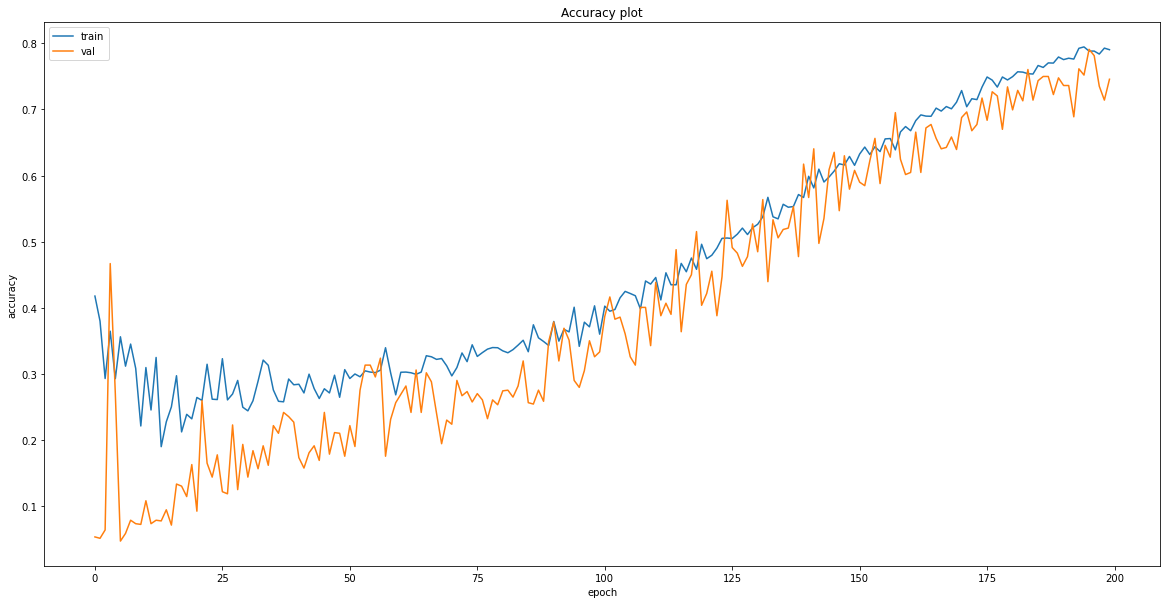

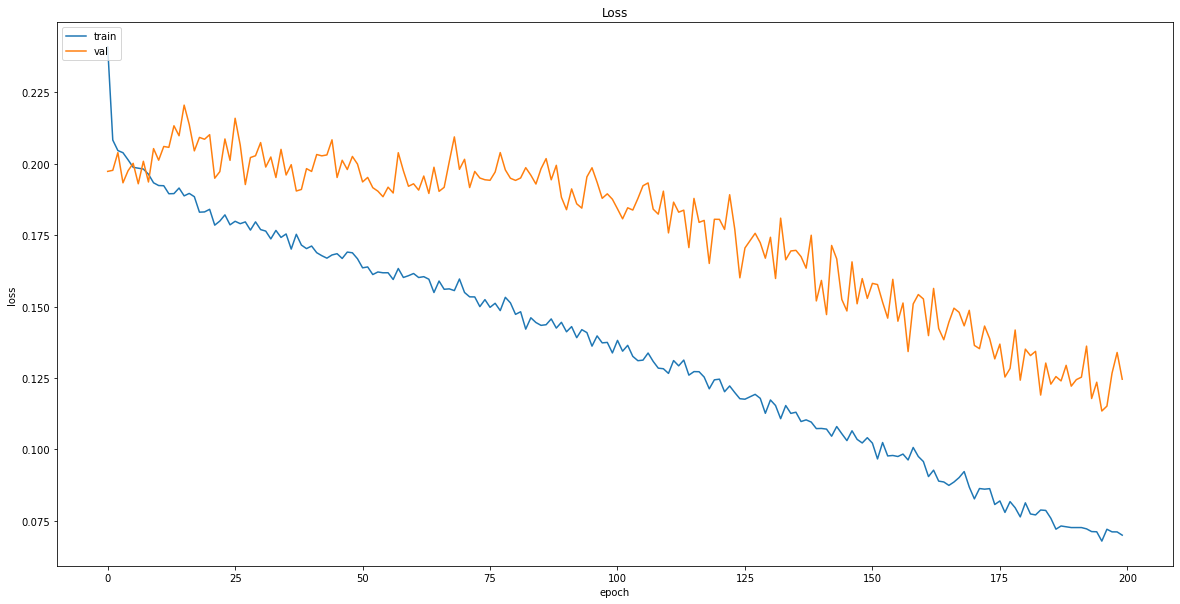

In [137]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [138]:
# Save model
model.save("models/{}".format('wmt_image_cnn_buy_hold_sell_5.model'))

INFO:tensorflow:Assets written to: models/wmt_image_cnn_buy_hold_sell_5.model\assets


### Test Performance

#### Non-Recession

In [139]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-02-05,94.769997,95.729495,-73.397490,42546200.0,2.0
2019-02-06,95.599998,95.709573,-60.096174,48646100.0,2.0
2019-02-07,95.639999,95.698869,-59.455134,52911000.0,2.0
2019-02-08,96.730003,95.857505,-41.987116,59921100.0,2.0
2019-02-11,95.580002,95.814812,-60.416634,53751900.0,2.0


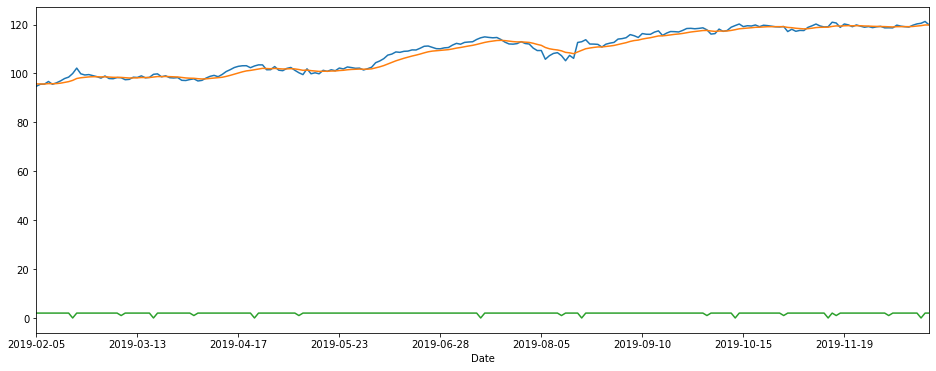

In [140]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [141]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_5_price = []
data_5_willr = []
data_5_ema = []
data_5_obv = []
count = 0

for i in df.values:
    if count == 4:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_price_arr = min_max_scaler.fit_transform(data_5_price)
        data_5_ema_arr = min_max_scaler.fit_transform(data_5_ema)
        data_5_willr_arr = min_max_scaler.fit_transform(data_5_willr)
        data_5_obv_arr = min_max_scaler.fit_transform(data_5_obv)
        price_data.append(data_5_price_arr)
        willr_data.append(data_5_willr_arr)
        ema_data.append(data_5_ema_arr)
        obv_data.append(data_5_obv_arr)
        labels.append(i[-1])
        data_5_price = data_5_price[1:]
        data_5_willr = data_5_willr[1:]
        data_5_obv = data_5_obv[1:]
        data_5_ema = data_5_ema[1:]
    
    else:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [142]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [143]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [144]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [145]:
model = tf.keras.models.load_model("models/wmt_image_cnn_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 7ms/step - loss: 0.1066 - accuracy: 0.7844 - mean_squared_error: 2.6287 - weighted_accuracy: 0.7844 - weighted_mean_squared_error: 2.6287
Test loss: 0.10659197717905045
Test accuracy: 0.7844036817550659


In [146]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 181, 0: 22, 1: 15})

In [147]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [148]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,96.199997,95.814812,-60.416634,53751900.0,2.0,2,2
2019-02-12,96.970001,95.874072,-50.480811,59294700.0,2.0,2,2
2019-02-13,97.940002,96.042676,-33.448300,65176000.0,2.0,0,2
2019-02-14,98.519997,96.334572,-16.724150,70634500.0,2.0,2,2
2019-02-15,99.989998,96.670792,-11.165857,77835300.0,2.0,2,2


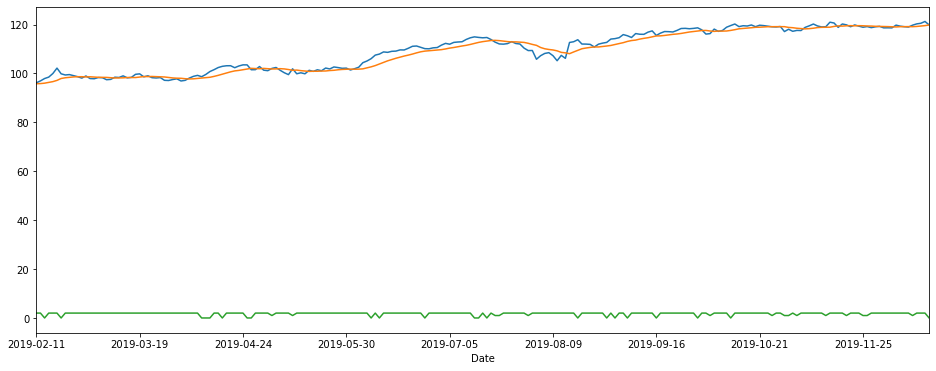

In [149]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['predictions'].plot(figsize=(16,6),x='Date', y='predictions')
#df['actual'].plot(figsize=(16,6),x='Date', y='actual')

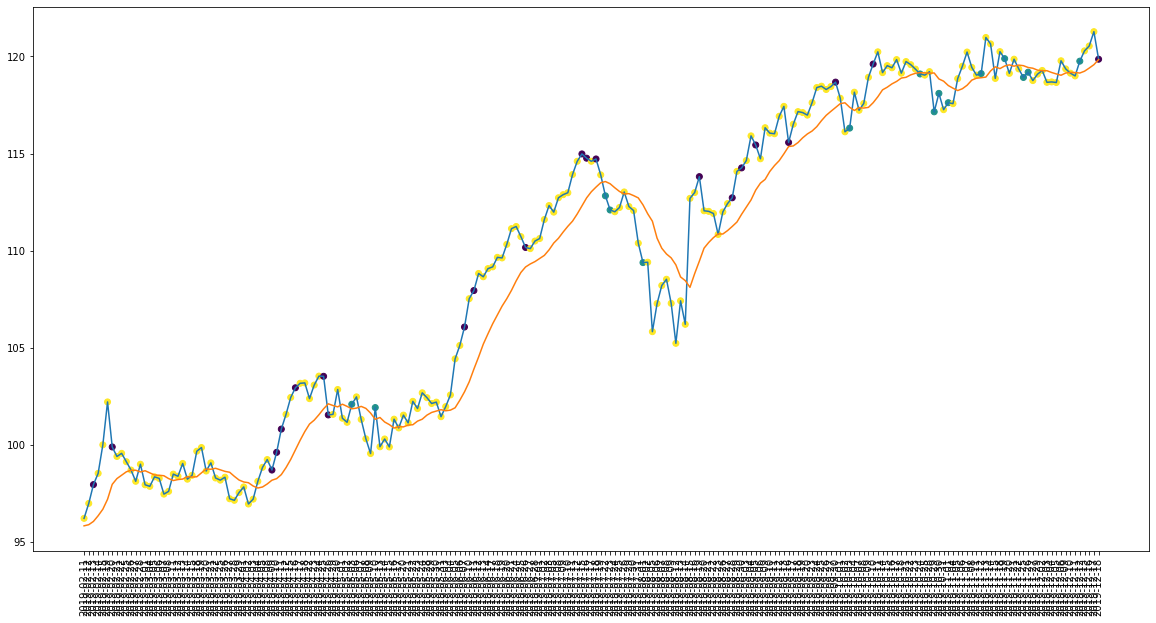

In [150]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

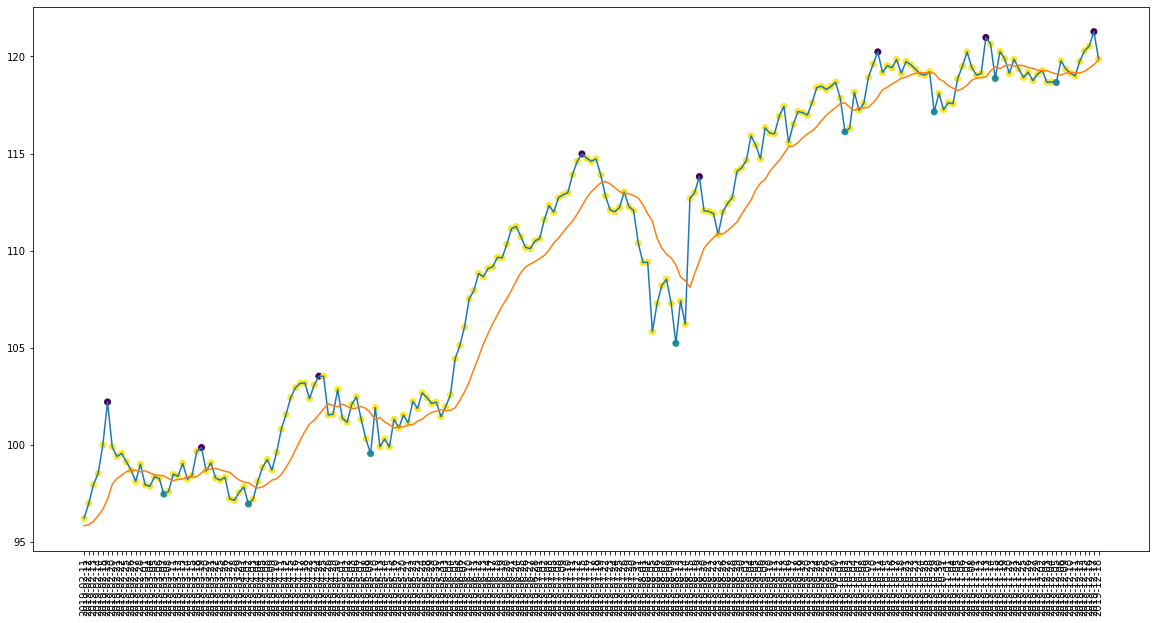

In [151]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [152]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 6
actual holds but predicted buy: 14
actual holds but predicted sell: 20
actual predicted holds: 168
Percentage buys correct: 12.5%
Percentage sells correct: 25.0%
Percentage holds correct: 83.16831683168317%
actual buys: 8
actual sells: 8
actual holds: 202


In [153]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[96.1999969482422, 96.97000122070312, 97.94000244140624, 98.5199966430664, 99.38999938964844, 99.5500030517578, 99.87999725341795, 99.98999786376952, 102.1999969482422]
[97.8499984741211, 97.93000030517578, 98.11000061035156, 98.69000244140624, 98.98999786376952, 99.12000274658205, 99.38999938964844, 99.5500030517578, 99.87999725341795]
Percentage buys correct: 66.66666666666667%
Percentage sells correct: 45.45454545454545%
Percentage holds correct: 86.11111111111111%


In [154]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $102.08000183105469
Shares owned at the moment: 97
Cash capital at the moment: $71.00998189926031


Price increase from previously bought: 5.450606937151359%
Share price: $107.94000244140624
Shares owned at the moment: 0
Cash capital at the moment: $10512.39722306442


Share price: $112.81999969482422
Shares owned at the moment: 92
Cash capital at the moment: $104.41379121780119


Stop Loss Activated!

Share price: $109.37999725341795
Shares owned at the moment: 0
Cash capital at the moment: $10139.700399227137


Share price: $109.37999725341795
Shares owned at the moment: 92
Cash capital at the moment: $49.06751260756937


Stop Loss Activated!

Share price: $105.81999969482422
Shares owned at the moment: 0
Cash capital at the moment: $9757.735024608606


Share price: $116.30999755859376
Shares owned at the moment: 83
Cash capital at the moment: $77.45747030257371




Capital at the end of test period: $9998.47947582244
profit gained: -0.01520524177560219%


In [155]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12375.78138288879
profit gained: 23.7578138288879%


### Recession

In [156]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/WMT_data_test2.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2020-02-05,115.269997,115.577902,-41.666781,-15247800.0,2.0
2020-02-06,116.809998,115.767455,-6.982095,-9564900.0,2.0
2020-02-07,116.309998,115.850923,-20.219894,-14917800.0,2.0
2020-02-10,116.449997,115.943088,-17.142986,-11228200.0,2.0
2020-02-11,115.250000,115.836459,-43.516528,-17373100.0,2.0


In [157]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_5_price = []
data_5_willr = []
data_5_ema = []
data_5_obv = []
count = 0

for i in df.values:
    if count == 4:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_price_arr = min_max_scaler.fit_transform(data_5_price)
        data_5_ema_arr = min_max_scaler.fit_transform(data_5_ema)
        data_5_willr_arr = min_max_scaler.fit_transform(data_5_willr)
        data_5_obv_arr = min_max_scaler.fit_transform(data_5_obv)
        price_data.append(data_5_price_arr)
        willr_data.append(data_5_willr_arr)
        ema_data.append(data_5_ema_arr)
        obv_data.append(data_5_obv_arr)
        labels.append(i[-1])
        data_5_price = data_5_price[1:]
        data_5_willr = data_5_willr[1:]
        data_5_obv = data_5_obv[1:]
        data_5_ema = data_5_ema[1:]
    
    else:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [158]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [159]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [160]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [161]:
model = tf.keras.models.load_model("models/wmt_image_cnn_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 7ms/step - loss: 0.1012 - accuracy: 0.7854 - mean_squared_error: 2.5292 - weighted_accuracy: 0.7854 - weighted_mean_squared_error: 2.5292
Test loss: 0.10118909180164337
Test accuracy: 0.7853881120681763


In [162]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 184, 0: 16, 1: 19})

In [163]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [164]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,115.400002,115.836459,-43.516528,-17373100.0,2.0,2,2
2020-02-12,115.849998,115.769312,-40.219793,-11576300.0,2.0,2,2
2020-02-13,117.440002,115.781725,-30.329757,-6840700.0,2.0,2,2
2020-02-14,117.889999,116.036845,-2.057582,-1507500.0,2.0,2,2
2020-02-18,119.629997,116.321946,-14.561040,6623100.0,0.0,2,0


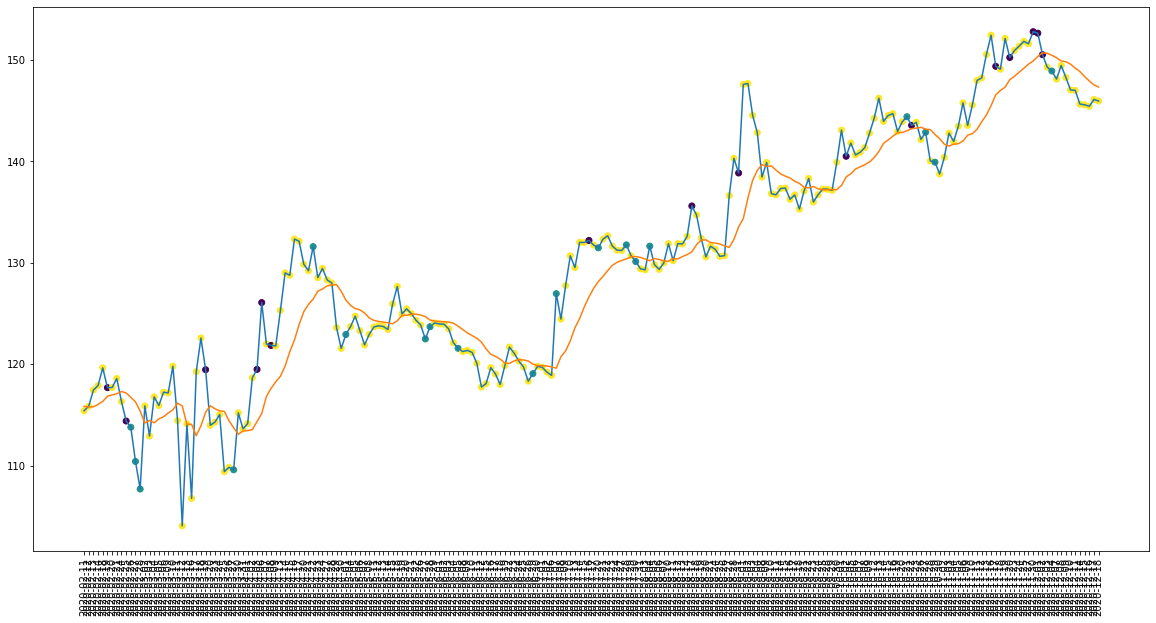

In [165]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

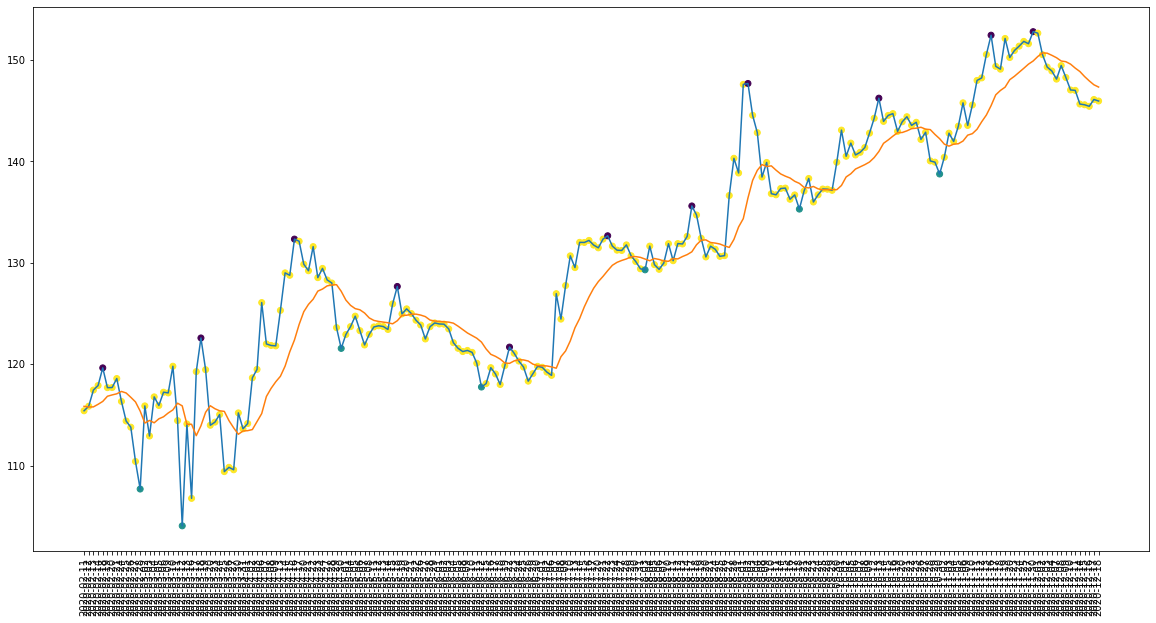

In [166]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [167]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 9
actual holds but predicted buy: 18
actual holds but predicted sell: 14
actual predicted holds: 169
Percentage buys correct: 14.285714285714286%
Percentage sells correct: 18.181818181818183%
Percentage holds correct: 84.07960199004975%
actual buys: 7
actual sells: 11
actual holds: 201


In [168]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[115.4000015258789, 115.8499984741211, 116.31999969482422, 117.44000244140624, 117.68000030517578, 117.69000244140624, 117.88999938964844, 118.58000183105469, 119.62999725341795]
[107.68000030517578, 110.4000015258789, 112.91000366210938, 113.77999877929688, 114.38999938964844, 115.87999725341795, 116.31999969482422, 117.69000244140624, 118.58000183105469]
Percentage buys correct: 63.1578947368421%
Percentage sells correct: 37.5%
Percentage holds correct: 85.24590163934427%


In [169]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $113.77999877929688
Shares owned at the moment: 87
Cash capital at the moment: $73.91824149322565


Stop Loss Activated!

Share price: $110.4000015258789
Shares owned at the moment: 0
Cash capital at the moment: $9652.305173879624


Share price: $110.4000015258789
Shares owned at the moment: 87
Cash capital at the moment: $21.091840763092478


Stop Loss Activated!

Share price: $104.0500030517578
Shares owned at the moment: 0
Cash capital at the moment: $9048.548143035887


Share price: $109.58000183105469
Shares owned at the moment: 82
Cash capital at the moment: $38.27770247650005


Price increase from previously bought: 8.735474033788293%
Share price: $119.4800033569336
Shares owned at the moment: 0
Cash capital at the moment: $9808.695236988066


Share price: $131.58999633789062
Shares owned at the moment: 74
Cash capital at the moment: $44.2569437293987


Stop Loss Activated!

Share price: $123.5999984741211
Shares owned at the moment: 0
Cash capital at the moment: $9

In [170]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $12565.490331684112
profit gained: 25.65490331684112%


## Fresh Del Monte Produce Inc

In [171]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14     OBV_7  labels
0  2000-01-21       8.7500  8.946622 -66.666667   78200.0     2.0
1  2000-01-24       8.8750  8.935603 -58.333333   99900.0     2.0
2  2000-01-25       9.0000  8.945511 -50.000000  123600.0     2.0
3  2000-01-26       8.6875  8.905817 -70.833333   87300.0     2.0
4  2000-01-27       8.5625  8.852999 -76.000000   32400.0     2.0


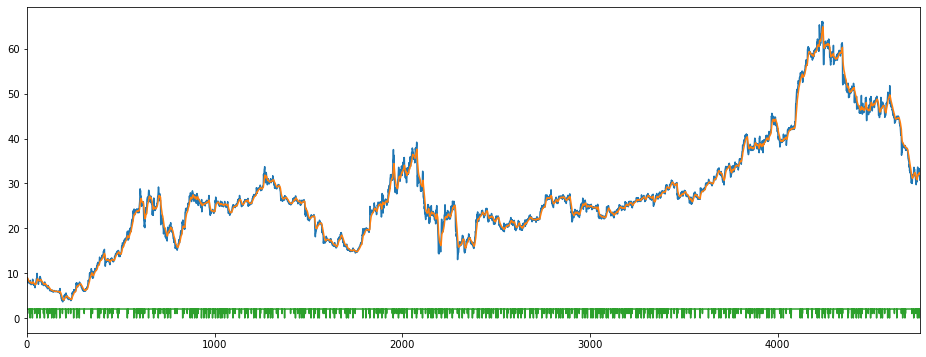

In [172]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [173]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,8.7500,8.946622,-66.666667,78200.0,2.0
2000-01-24,8.8750,8.935603,-58.333333,99900.0,2.0
2000-01-25,9.0000,8.945511,-50.000000,123600.0,2.0
2000-01-26,8.6875,8.905817,-70.833333,87300.0,2.0
2000-01-27,8.5625,8.852999,-76.000000,32400.0,2.0


In [174]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_5_price = []
data_5_willr = []
data_5_ema = []
data_5_obv = []
count = 0

for i in df.values:
    if count == 4:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_price_arr = min_max_scaler.fit_transform(data_5_price)
        data_5_ema_arr = min_max_scaler.fit_transform(data_5_ema)
        data_5_willr_arr = min_max_scaler.fit_transform(data_5_willr)
        data_5_obv_arr = min_max_scaler.fit_transform(data_5_obv)
        price_data.append(data_5_price_arr)
        willr_data.append(data_5_willr_arr)
        ema_data.append(data_5_ema_arr)
        obv_data.append(data_5_obv_arr)
        labels.append(i[-1])
        data_5_price = data_5_price[1:]
        data_5_willr = data_5_willr[1:]
        data_5_obv = data_5_obv[1:]
        data_5_ema = data_5_ema[1:]
    
    else:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        count += 1

In [175]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [176]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [177]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4755, 64, 64, 1)

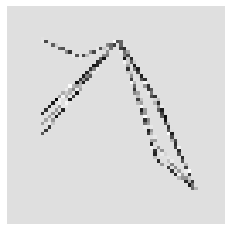

In [178]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [179]:
X = X/255

In [180]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [181]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [182]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [183]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [184]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.287356321839081, 1: 7.163841807909605, 2: 0.3672169128294237}
Epoch 1/200
30/30 [==============================] - 2s 62ms/step - loss: 0.2442 - accuracy: 0.3825 - mse: 1.7393 - weighted_accuracy: 0.3441 - weighted_mse: 1.7215 - val_loss: 0.2175 - val_accuracy: 0.0536 - val_mse: 1.0501 - val_weighted_accuracy: 0.0536 - val_weighted_mse: 1.0501
Epoch 2/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2102 - accuracy: 0.2892 - mse: 1.2540 - weighted_accuracy: 0.3280 - weighted_mse: 1.2433 - val_loss: 0.2027 - val_accuracy: 0.0452 - val_mse: 0.9835 - val_weighted_accuracy: 0.0452 - val_weighted_mse: 0.9835
Epoch 3/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2054 - accuracy: 0.3486 - mse: 1.1778 - weighted_accuracy: 0.3476 - weighted_mse: 1.1691 - val_loss: 0.1976 - val_accuracy: 0.2660 - val_mse: 0.9412 - val_weighted_accuracy: 0.2660 - val_weighted_mse: 0.9412
Epoch 4/200
30/30 [==============================] - 0s 9ms/step - loss: 0.2049 - 

30/30 [==============================] - 0s 9ms/step - loss: 0.1914 - accuracy: 0.2957 - mse: 1.1992 - weighted_accuracy: 0.4328 - weighted_mse: 1.1877 - val_loss: 0.1967 - val_accuracy: 0.1956 - val_mse: 0.9295 - val_weighted_accuracy: 0.1956 - val_weighted_mse: 0.9295
Epoch 29/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1924 - accuracy: 0.2808 - mse: 1.2105 - weighted_accuracy: 0.4304 - weighted_mse: 1.1947 - val_loss: 0.1898 - val_accuracy: 0.2650 - val_mse: 0.9833 - val_weighted_accuracy: 0.2650 - val_weighted_mse: 0.9833
Epoch 30/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1941 - accuracy: 0.2755 - mse: 1.2018 - weighted_accuracy: 0.3948 - weighted_mse: 1.1831 - val_loss: 0.1916 - val_accuracy: 0.2776 - val_mse: 1.0392 - val_weighted_accuracy: 0.2776 - val_weighted_mse: 1.0392
Epoch 31/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1907 - accuracy: 0.2750 - mse: 1.2314 - weighted_accuracy: 0.4290 - weighted_mse: 1.2

Epoch 57/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1781 - accuracy: 0.2192 - mse: 1.3205 - weighted_accuracy: 0.4932 - weighted_mse: 1.2664 - val_loss: 0.1912 - val_accuracy: 0.1767 - val_mse: 1.1271 - val_weighted_accuracy: 0.1767 - val_weighted_mse: 1.1271
Epoch 58/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1776 - accuracy: 0.2342 - mse: 1.3176 - weighted_accuracy: 0.4627 - weighted_mse: 1.2812 - val_loss: 0.1931 - val_accuracy: 0.1672 - val_mse: 1.0363 - val_weighted_accuracy: 0.1672 - val_weighted_mse: 1.0363
Epoch 59/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1783 - accuracy: 0.2056 - mse: 1.3086 - weighted_accuracy: 0.4812 - weighted_mse: 1.2689 - val_loss: 0.1879 - val_accuracy: 0.1809 - val_mse: 1.1757 - val_weighted_accuracy: 0.1809 - val_weighted_mse: 1.1757
Epoch 60/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1800 - accuracy: 0.1914 - mse: 1.3246 - weighted_accuracy: 0.4831 - weig

Epoch 86/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1613 - accuracy: 0.1743 - mse: 1.4190 - weighted_accuracy: 0.5618 - weighted_mse: 1.3653 - val_loss: 0.1937 - val_accuracy: 0.1935 - val_mse: 1.3022 - val_weighted_accuracy: 0.1935 - val_weighted_mse: 1.3022
Epoch 87/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1605 - accuracy: 0.1861 - mse: 1.4472 - weighted_accuracy: 0.5878 - weighted_mse: 1.4092 - val_loss: 0.1931 - val_accuracy: 0.1735 - val_mse: 1.2440 - val_weighted_accuracy: 0.1735 - val_weighted_mse: 1.2440
Epoch 88/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1616 - accuracy: 0.1953 - mse: 1.4496 - weighted_accuracy: 0.5674 - weighted_mse: 1.4034 - val_loss: 0.1917 - val_accuracy: 0.1966 - val_mse: 1.2824 - val_weighted_accuracy: 0.1966 - val_weighted_mse: 1.2824
Epoch 89/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1596 - accuracy: 0.1822 - mse: 1.4113 - weighted_accuracy: 0.5715 - weig

Epoch 115/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1477 - accuracy: 0.2445 - mse: 1.6043 - weighted_accuracy: 0.6395 - weighted_mse: 1.5443 - val_loss: 0.1896 - val_accuracy: 0.2450 - val_mse: 1.3728 - val_weighted_accuracy: 0.2450 - val_weighted_mse: 1.3728
Epoch 116/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1438 - accuracy: 0.2616 - mse: 1.6121 - weighted_accuracy: 0.6655 - weighted_mse: 1.5704 - val_loss: 0.1918 - val_accuracy: 0.2166 - val_mse: 1.4362 - val_weighted_accuracy: 0.2166 - val_weighted_mse: 1.4362
Epoch 117/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1458 - accuracy: 0.2574 - mse: 1.6004 - weighted_accuracy: 0.6388 - weighted_mse: 1.5730 - val_loss: 0.1888 - val_accuracy: 0.2702 - val_mse: 1.4768 - val_weighted_accuracy: 0.2702 - val_weighted_mse: 1.4768
Epoch 118/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1398 - accuracy: 0.2729 - mse: 1.6706 - weighted_accuracy: 0.6769 - 

Epoch 144/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1301 - accuracy: 0.3946 - mse: 1.8854 - weighted_accuracy: 0.7014 - weighted_mse: 1.9915 - val_loss: 0.1741 - val_accuracy: 0.4280 - val_mse: 1.6301 - val_weighted_accuracy: 0.4280 - val_weighted_mse: 1.6301
Epoch 145/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1274 - accuracy: 0.4117 - mse: 1.8945 - weighted_accuracy: 0.7042 - weighted_mse: 2.0421 - val_loss: 0.1776 - val_accuracy: 0.4311 - val_mse: 1.7267 - val_weighted_accuracy: 0.4311 - val_weighted_mse: 1.7267
Epoch 146/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1255 - accuracy: 0.3899 - mse: 1.9192 - weighted_accuracy: 0.6998 - weighted_mse: 2.1098 - val_loss: 0.1708 - val_accuracy: 0.4679 - val_mse: 1.6660 - val_weighted_accuracy: 0.4679 - val_weighted_mse: 1.6660
Epoch 147/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1313 - accuracy: 0.4077 - mse: 1.8708 - weighted_accuracy: 0.6755 - 

Epoch 173/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1173 - accuracy: 0.5279 - mse: 2.2312 - weighted_accuracy: 0.7286 - weighted_mse: 2.6187 - val_loss: 0.1702 - val_accuracy: 0.4953 - val_mse: 1.8460 - val_weighted_accuracy: 0.4953 - val_weighted_mse: 1.8460
Epoch 174/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1171 - accuracy: 0.5415 - mse: 2.2185 - weighted_accuracy: 0.7446 - weighted_mse: 2.6096 - val_loss: 0.1513 - val_accuracy: 0.6162 - val_mse: 1.8395 - val_weighted_accuracy: 0.6162 - val_weighted_mse: 1.8395
Epoch 175/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1146 - accuracy: 0.5434 - mse: 2.2662 - weighted_accuracy: 0.7489 - weighted_mse: 2.6019 - val_loss: 0.1508 - val_accuracy: 0.6288 - val_mse: 1.9184 - val_weighted_accuracy: 0.6288 - val_weighted_mse: 1.9184
Epoch 176/200
30/30 [==============================] - 0s 9ms/step - loss: 0.1143 - accuracy: 0.5492 - mse: 2.2973 - weighted_accuracy: 0.7474 - 

In [185]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.14239346981048584
Test accuracy: 0.6687697172164917


In [186]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.33199805 -2.829724   -0.43497178]
 [-1.5483747  -0.91620153 -0.20403719]
 [-0.87251234 -1.6201417  -0.12121207]
 ...
 [-1.9975723  -0.60660547 -0.38419825]
 [-0.76913416 -1.6844962  -0.19178271]
 [-0.6598605  -2.1677625  -0.26154125]]


Counter({0: 162, 2: 664, 1: 125})

In [187]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 864, 0: 43, 1: 44})

In [188]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 951
actual predicted buys: 14
actual buys but predicted sell: 2
actual buys but predicted hold: 28
actual sells but predicted buy: 1
actual predicted sells: 14
actual sells but predicted hold: 28
actual holds but predicted buy: 110
actual holds but predicted sell: 146
actual predicted holds: 608
Percentage buys correct: 31.818181818181817%
Percentage sells correct: 32.55813953488372%
Percentage holds correct: 70.37037037037037%
actual buys: 44
actual sells: 43
actual holds: 864


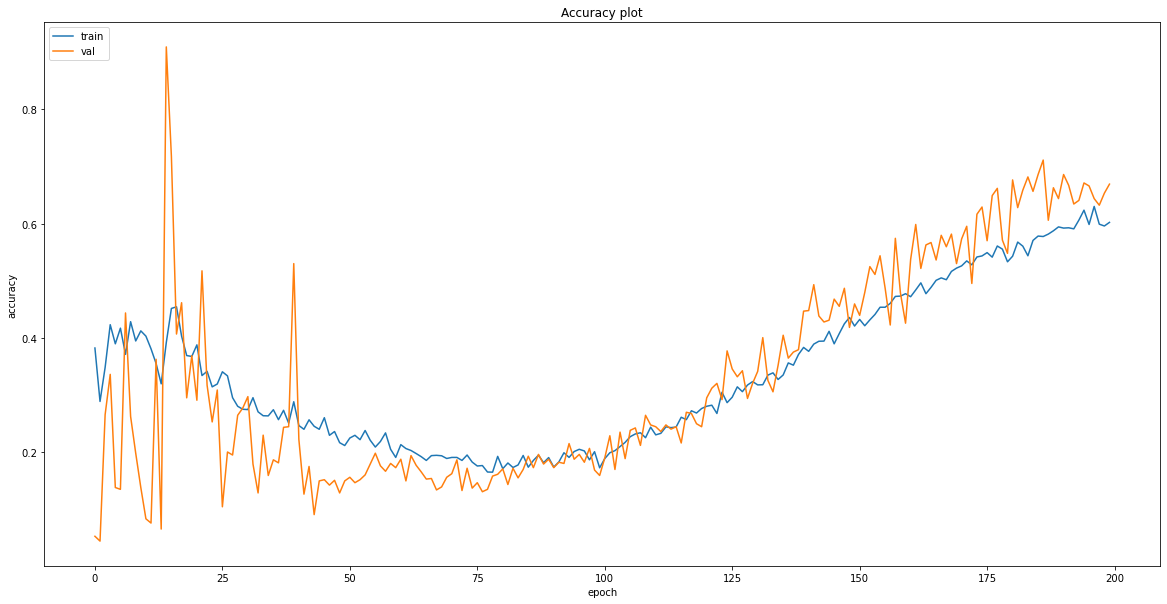

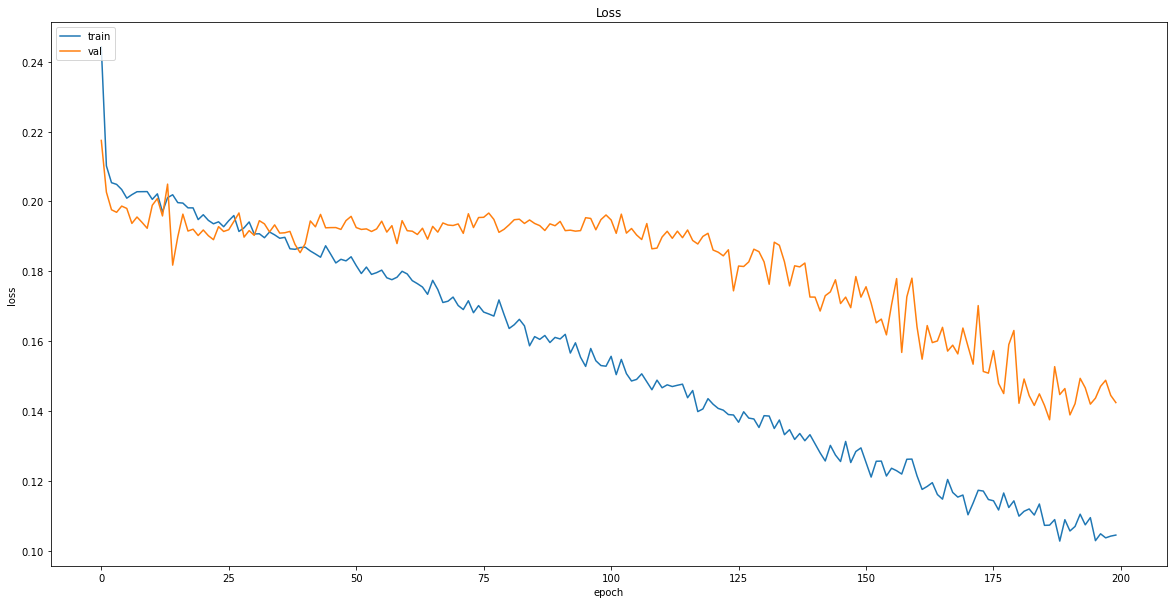

In [189]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [190]:
# Save model
model.save("models/{}".format('FDP_image_cnn_buy_hold_sell_5.model'))

INFO:tensorflow:Assets written to: models/FDP_image_cnn_buy_hold_sell_5.model\assets


### Test Performance

### non-recession

In [191]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-02-05,32.270000,31.221691,-2.583014,2341900.0,2.0
2019-02-06,32.529999,31.422969,-6.451637,2446400.0,2.0
2019-02-07,32.380001,31.570205,-12.698342,2354600.0,2.0
2019-02-08,32.240002,31.673251,-17.589484,2224500.0,2.0
2019-02-11,33.660000,31.978904,-0.753738,2502700.0,2.0


In [192]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_5_price = []
data_5_willr = []
data_5_ema = []
data_5_obv = []
count = 0

for i in df.values:
    if count == 4:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_price_arr = min_max_scaler.fit_transform(data_5_price)
        data_5_ema_arr = min_max_scaler.fit_transform(data_5_ema)
        data_5_willr_arr = min_max_scaler.fit_transform(data_5_willr)
        data_5_obv_arr = min_max_scaler.fit_transform(data_5_obv)
        price_data.append(data_5_price_arr)
        willr_data.append(data_5_willr_arr)
        ema_data.append(data_5_ema_arr)
        obv_data.append(data_5_obv_arr)
        labels.append(i[-1])
        data_5_price = data_5_price[1:]
        data_5_willr = data_5_willr[1:]
        data_5_obv = data_5_obv[1:]
        data_5_ema = data_5_ema[1:]
    
    else:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [193]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [194]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [195]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [196]:
model = tf.keras.models.load_model("models/FDP_image_cnn_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1509 - accuracy: 0.5734 - mean_squared_error: 2.2651 - weighted_accuracy: 0.5734 - weighted_mean_squared_error: 2.2651
Test loss: 0.15092036128044128
Test accuracy: 0.5733944773674011


In [197]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 55, 2: 129, 1: 34})

In [198]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [199]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,33.880001,31.978904,-0.753738,2502700.0,2.0,0,2
2019-02-12,34.610001,32.271381,-0.536205,2611700.0,2.0,0,2
2019-02-13,34.810001,32.631168,-5.603413,2713000.0,2.0,0,2
2019-02-14,34.430000,32.966373,-5.668932,2794100.0,2.0,2,2
2019-02-15,35.220001,33.191547,-14.285733,2675800.0,0.0,2,0


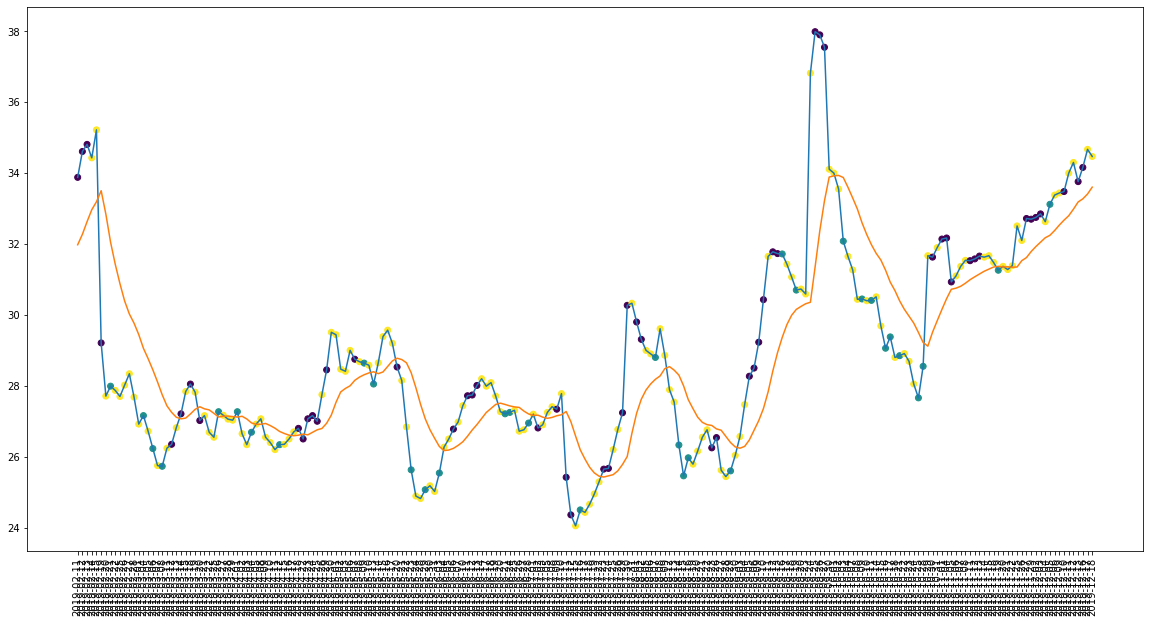

In [200]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

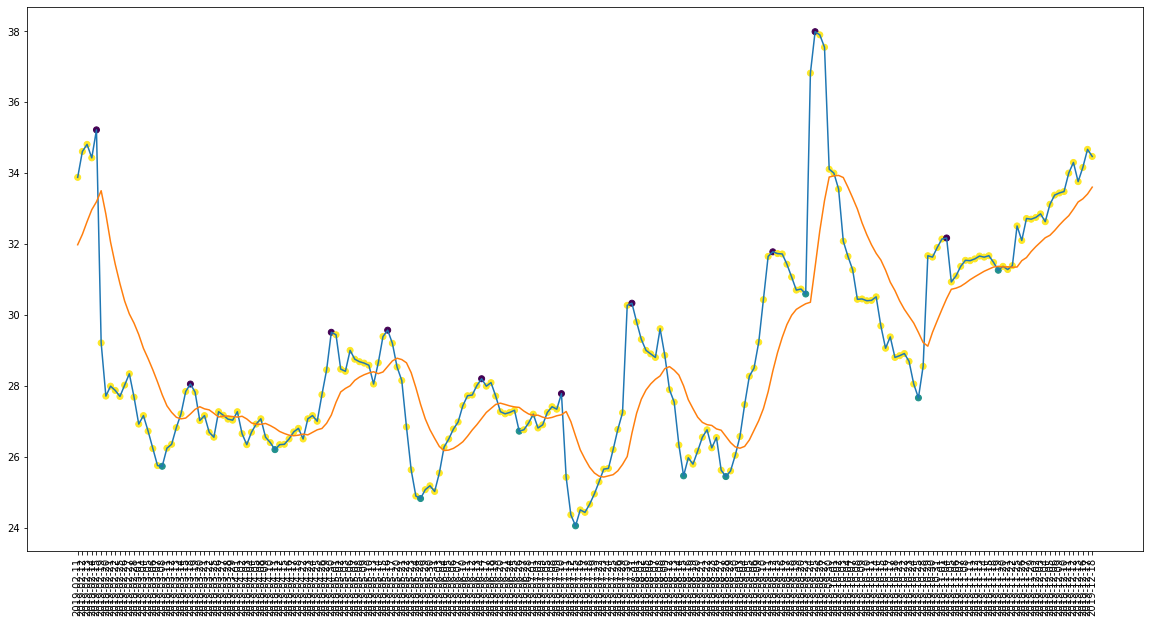

In [201]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [202]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 30
actual holds but predicted sell: 51
actual predicted holds: 117
Percentage buys correct: 40.0%
Percentage sells correct: 40.0%
Percentage holds correct: 59.09090909090909%
actual buys: 10
actual sells: 10
actual holds: 198


In [203]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[27.709999084472656, 27.8700008392334, 27.989999771118164, 29.209999084472656, 33.880001068115234, 34.43000030517578, 34.610000610351555, 34.810001373291016, 35.220001220703125]
[26.920000076293945, 27.15999984741211, 27.68000030517578, 27.70000076293945, 27.709999084472656, 27.8700008392334, 27.989999771118164, 28.020000457763672, 28.34000015258789]
Percentage buys correct: 52.94117647058823%
Percentage sells correct: 50.90909090909091%
Percentage holds correct: 82.03125%


In [204]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $27.989999771118164
Shares owned at the moment: 356
Cash capital at the moment: $8.157871706009246


Stop Loss Activated!

Share price: $26.920000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9565.323218791962


Share price: $27.15999984741211
Shares owned at the moment: 351
Cash capital at the moment: $5.947082497596057


Stop Loss Activated!

Share price: $26.229999542236328
Shares owned at the moment: 0
Cash capital at the moment: $9187.358414764403


Share price: $26.229999542236328
Shares owned at the moment: 349
Cash capital at the moment: $7.914332463262326


Price increase from previously bought: 6.645344162062505%
Share price: $28.04999923706055
Shares owned at the moment: 0
Cash capital at the moment: $9770.443079429626


Share price: $27.270000457763672
Shares owned at the moment: 357
Cash capital at the moment: $8.28059305858551


Stop Loss Activated!

Share price: $26.34000015258789
Shares owned at the moment: 0
Cash capital at the momen

In [205]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $10118.19906801033
profit gained: 1.1819906801032993%


### recession

In [206]:
seed = 10
df = pd.read_csv("data/noncyclic_tickers/initial_indicators/FDP_data_test2.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2020-02-05,31.209999,32.420759,-94.776143,-266300.0,2.0
2020-02-06,32.360001,32.411412,-66.169143,-148200.0,2.0
2020-02-07,32.389999,32.408118,-65.422905,-37200.0,2.0
2020-02-10,33.000000,32.499176,-47.089930,183100.0,2.0
2020-02-11,33.680000,32.680842,-26.373606,310600.0,2.0


In [207]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_5_price = []
data_5_willr = []
data_5_ema = []
data_5_obv = []
count = 0

for i in df.values:
    if count == 4:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_price_arr = min_max_scaler.fit_transform(data_5_price)
        data_5_ema_arr = min_max_scaler.fit_transform(data_5_ema)
        data_5_willr_arr = min_max_scaler.fit_transform(data_5_willr)
        data_5_obv_arr = min_max_scaler.fit_transform(data_5_obv)
        price_data.append(data_5_price_arr)
        willr_data.append(data_5_willr_arr)
        ema_data.append(data_5_ema_arr)
        obv_data.append(data_5_obv_arr)
        labels.append(i[-1])
        data_5_price = data_5_price[1:]
        data_5_willr = data_5_willr[1:]
        data_5_obv = data_5_obv[1:]
        data_5_ema = data_5_ema[1:]
    
    else:
        data_5_price.append([i[0]])
        data_5_ema.append([i[1]])
        data_5_willr.append([i[2]])
        data_5_obv.append([i[3]])
        count += 1
        
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [208]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [209]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
X = X/255
y = np.array(y)

In [210]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [211]:
model = tf.keras.models.load_model("models/FDP_image_cnn_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1389 - accuracy: 0.6804 - mean_squared_error: 2.0860 - weighted_accuracy: 0.6804 - weighted_mean_squared_error: 2.0860
Test loss: 0.13888715207576752
Test accuracy: 0.6803653240203857


In [212]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({0: 34, 2: 157, 1: 28})

In [213]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [214]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,33.930000,32.680842,-26.373606,310600.0,2.0,0,2
2020-02-12,34.410000,32.873020,-19.505473,431300.0,2.0,2,2
2020-02-13,34.240002,33.109478,-14.750004,582800.0,2.0,0,2
2020-02-14,34.480000,33.283405,-18.999958,490800.0,0.0,2,0
2020-02-18,34.009998,33.467496,-13.000011,587800.0,2.0,2,2


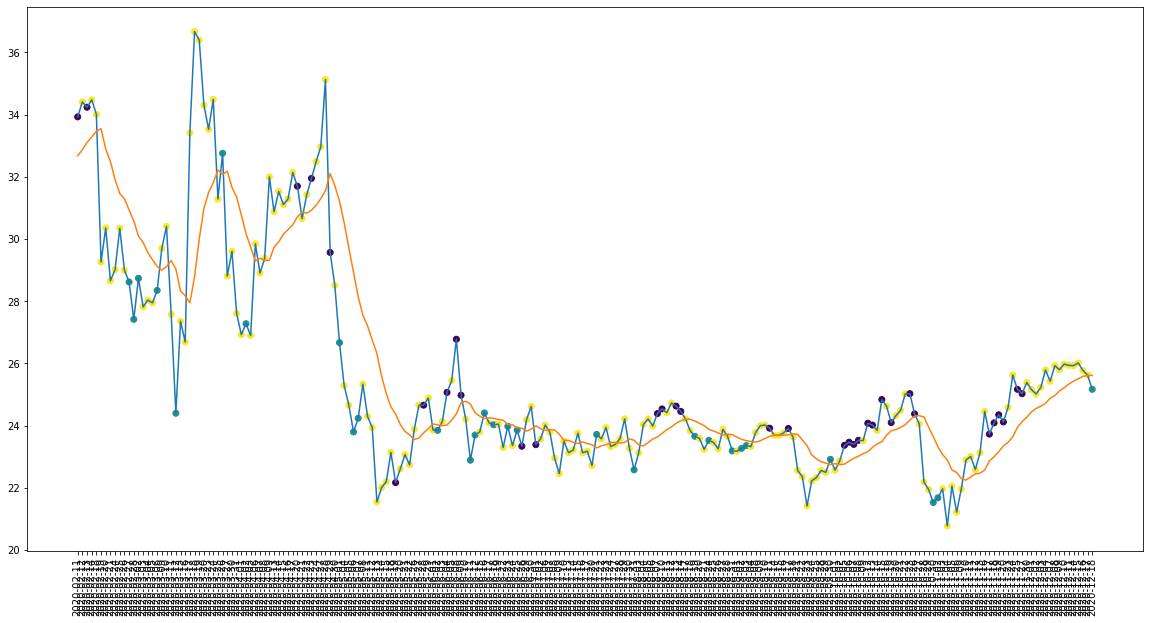

In [215]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

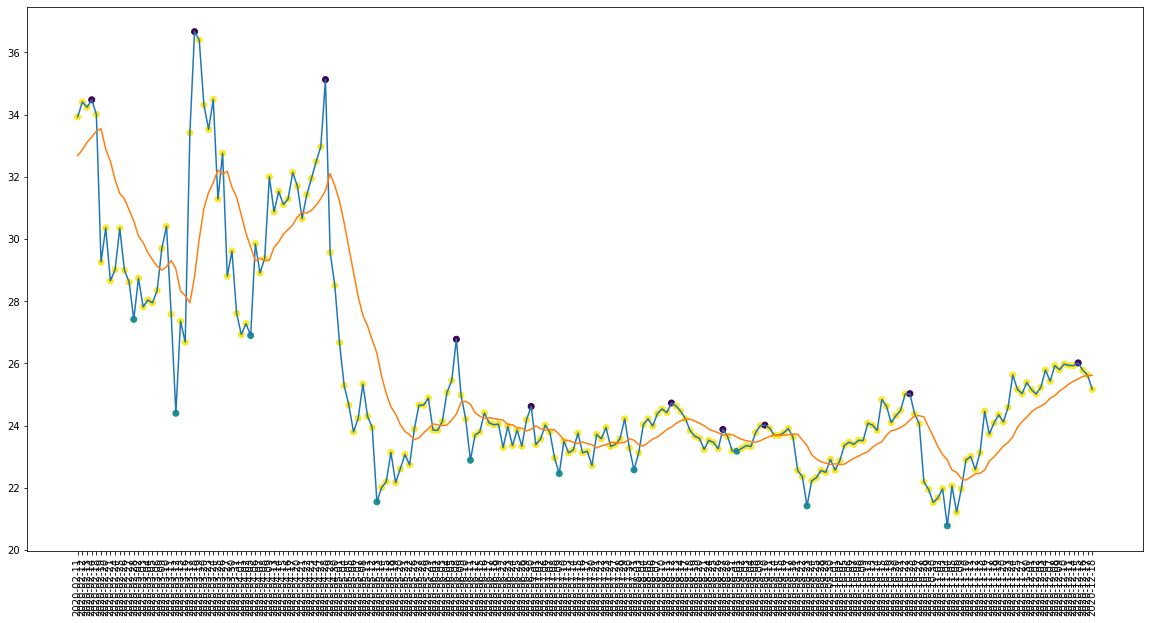

In [216]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [217]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 24
actual holds but predicted sell: 32
actual predicted holds: 143
Percentage buys correct: 40.0%
Percentage sells correct: 20.0%
Percentage holds correct: 71.85929648241206%
actual buys: 10
actual sells: 10
actual holds: 199


In [218]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[28.65999984741211, 29.020000457763672, 29.26000022888184, 30.36000061035156, 33.93000030517578, 34.009998321533196, 34.240001678466804, 34.40999984741211, 34.47999954223633]
[27.420000076293945, 27.81999969482422, 28.6200008392334, 28.65999984741211, 28.739999771118164, 29.0, 29.020000457763672, 30.35000038146973, 30.36000061035156]
Percentage buys correct: 57.142857142857146%
Percentage sells correct: 52.94117647058823%
Percentage holds correct: 82.6923076923077%


In [219]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $28.6200008392334
Shares owned at the moment: 348
Cash capital at the moment: $12.850367143630137


Stop Loss Activated!

Share price: $27.420000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9528.76945362091


Share price: $27.420000076293945
Shares owned at the moment: 346
Cash capital at the moment: $15.359297150609564


Stop Loss Activated!

Share price: $24.399999618530273
Shares owned at the moment: 0
Cash capital at the moment: $8434.542565525053


Share price: $24.399999618530273
Shares owned at the moment: 344
Cash capital at the moment: $17.86029711150877


Price increase from previously bought: 29.56174315115987%
Share price: $31.70000076293945
Shares owned at the moment: 0
Cash capital at the moment: $10892.672358840939


Share price: $26.670000076293945
Shares owned at the moment: 407
Cash capital at the moment: $8.131930203910088


Stop Loss Activated!

Share price: $25.290000915527344
Shares owned at the moment: 0
Cash capital at the mo

In [220]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7385.700107630253
profit gained: -26.14299892369747%
